# **Predictive Modeling for Early Hospital Readmission Among Diabetes Patients**

**Coursework for MSc Bioinformatics Program**  
**Module:** CO7093 Big Data and Predictive Analytics  
**Academic Year:** 2023-24 SEM2  
**Objective:** Develop a classification model to predict the likelihood of early hospital readmission (<30 days) for patients diagnosed with diabetes.  

---

**Dataset Overview:**  
This analysis utilizes a dataset covering ten years (1999-2008) of clinical care data from 130 US hospitals and integrated delivery networks. It includes 47 features across 101766 instances, focusing on patients diagnosed with diabetes.

**Key Steps in the Analysis:**  
1. **Data Cleaning and Transformation:** Handle missing values and inconsistencies in the dataset to prepare it for analysis.
2. **Data Visualisation:** Visualize the data to uncover patterns and insights that could inform the predictive modeling.
3. **Initial Predictive Modeling and Evaluation:** Build an initial linear model using appropriate predictors and evaluate its performance using cross-validation and relevant metrics. Address class imbalance by applying data balancing techniques and reassess model performance.
4. **Improved Modeling:** Develop an enhanced classification model aiming for higher performance while maximizing data utilization. Apply K-Means clustering to the dataset and compare cluster distribution to the original data. Build and evaluate local classifiers based on the obtained clusters, comparing their performance to the initial global model. Investigate the impact of data balancing on the improved model's performance.

---

By following this structured approach, we aim to provide valuable insights into factors affecting early readmission rates among diabetes patients, thereby contributing to improved patient care and resource management in hospitals.

### Downloading the right packages and the data file (optional)

In [605]:
!pip freeze | grep diffusers==0.27.2 || (pip install diffusers==0.27.2)
!pip freeze | grep pandas==2.1.2 || (pip install pandas==2.1.2)
!pip freeze | grep scikit-learn==1.2.2 || (pip install scikit-learn==1.2.2)
!pip freeze | grep numpy==1.23.5 || (pip install numpy==1.23.5 scipy==1.10.1)
!pip freeze | grep matplotlib==3.8.0|| (pip install matplotlib==3.8.0)
!pip freeze | grep seaborn==0.13.0|| (pip install seaborn==0.13.0)
!pip freeze | grep imbalanced-learn==0.10.1|| (pip install imbalanced-learn==0.10.1)
!pip freeze | grep yellowbrick|| (pip install yellowbrick)
!if [ ! -f diabetic_data.csv ]; then wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1Pnd_I9iEuIX8_13jE8uqt2WZ16u0ApKF' -O diabetic_data.csv; fi

diffusers==0.27.2
pandas==2.1.2
scikit-learn==1.2.2
numpy==1.23.5
matplotlib==3.8.0
seaborn==0.13.0
imbalanced-learn==0.10.1
yellowbrick==1.5


### Importing the packages

In [606]:
import pandas as pd # pandas==2.1.2
import numpy as np # numpy==1.23.5
import matplotlib.pyplot as plt # matplotlib==3.8.0
import seaborn as sns # seaborn==0.13.0
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, RobustScaler, LabelEncoder # scikit-learn==1.2.2
from sklearn.impute import KNNImputer, SimpleImputer # scikit-learn==1.2.2
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, StratifiedKFold, KFold # scikit-learn==1.2.2
from sklearn.exceptions import ConvergenceWarning # scikit-learn==1.2.2
from sklearn.linear_model import LogisticRegression # scikit-learn==1.2.2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, make_scorer, RocCurveDisplay # scikit-learn==1.2.2
from sklearn.feature_selection import RFECV
from imblearn.combine import SMOTEENN # imbalanced-learn==0.10.1
from imblearn.over_sampling import SMOTE # imbalanced-learn==0.10.1
from imblearn.under_sampling import RandomUnderSampler # imbalanced-learn==0.10.1
from sklearn.cluster import KMeans # scikit-learn==1.2.2
from sklearn.decomposition import PCA # scikit-learn==1.2.2
from scipy import stats # scipy==1.10.1
from sklearn.ensemble import RandomForestClassifier # scikit-learn==1.2.2
from sklearn.experimental import enable_iterative_imputer # scikit-learn==1.2.2
from sklearn.feature_selection import RFECV # scikit-learn==1.2.2
from collections import defaultdict
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance
import warnings
from sklearn.datasets import make_blobs

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Importing the data

In [607]:
diabetes_df = pd.read_csv('diabetic_data.csv')

In [608]:
pd.set_option('display.max_columns', None)
diabetes_df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1          ?  Pediatrics-Endocrinology                  41   
1                 3          ?                         ?                  59   
2                 2          ?                         ?                  11   
3                 2          ?                         ?                  44   
4                 1          ?                         ?                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum  \
0                 0  250.83       ?      ?                 1           NaN   
1                 0     276  250.01    255                 9           NaN   
2                 1     648     250    V27                 6           NaN   
3                 0       8  250.43    403                 7           NaN   
4                 0     197     157    250                 5           NaN   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0       NaN        No          No          No             No          No   
1       NaN        No          No          No             No          No   
2       NaN        No          No          No             No          No   
3       NaN        No          No          No             No          No   
4       NaN        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No    Steady        No          No           No            No   
3            No        No        No          No           No            No   
4            No    Steady        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No      Up   
2       No       No           No         No      No          No      No   
3       No       No           No         No      No          No      Up   
4       No       No           No         No      No          No  Steady   

  glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
0                  No                  No                       No   
1                  No                  No                       No   
2                  No                  No                       No   
3                  No                  No                       No   
4        

In [609]:
diabetes_curated = diabetes_df.copy()

# 1. Data Cleaning and Transformation

### Showing the shape of the data

In [610]:
diabetes_curated.shape

(101766, 50)

### Removing the 'encounter_id' column from the dataframe

In [611]:
diabetes_curated.drop(columns=['encounter_id'], inplace=True)

In [612]:
diabetes_curated.head()

patient_nbr             race  gender      age weight  admission_type_id  \
0      8222157        Caucasian  Female   [0-10)      ?                  6   
1     55629189        Caucasian  Female  [10-20)      ?                  1   
2     86047875  AfricanAmerican  Female  [20-30)      ?                  1   
3     82442376        Caucasian    Male  [30-40)      ?                  1   
4     42519267        Caucasian    Male  [40-50)      ?                  1   

   discharge_disposition_id  admission_source_id  time_in_hospital payer_code  \
0                        25                    1                 1          ?   
1                         1                    7                 3          ?   
2                         1                    7                 2          ?   
3                         1                    7                 2          ?   
4                         1                    7                 1          ?   

          medical_specialty  num_lab_procedures  num_procedures  \
0  Pediatrics-Endocrinology                  41               0   
1                         ?                  59               0   
2                         ?                  11               5   
3                         ?                  44               1   
4                         ?                  51               0   

   num_medications  number_outpatient  number_emergency  number_inpatient  \
0                1                  0                 0                 0   
1               18                  0                 0                 0   
2               13                  2                 0                 1   
3               16                  0                 0                 0   
4                8                  0                 0                 0   

   diag_1  diag_2 diag_3  number_diagnoses max_glu_serum A1Cresult metformin  \
0  250.83       ?      ?                 1           NaN       NaN        No   
1     276  250.01    255                 9           NaN       NaN        No   
2     648     250    V27                 6           NaN       NaN        No   
3       8  250.43    403                 7           NaN       NaN        No   
4     197     157    250                 5           NaN       NaN        No   

  repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide  \
0          No          No             No          No            No        No   
1          No          No             No          No            No        No   
2          No          No             No          No            No    Steady   
3          No          No             No          No            No        No   
4          No          No             No          No            No    Steady   

  glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol  \
0        No          No           No            No       No       No   
1        No          No           No            No       No       No   
2        No          No           No            No       No       No   
3        No          No           No            No       No       No   
4        No          No           No            No       No       No   

  troglitazone tolazamide examide citoglipton insulin glyburide-metformin  \
0           No         No      No          No      No                  No   
1           No         No      No          No      Up                  No   
2           No         No      No          No      No                  No   
3           No         No      No          No      Up                  No   
4           No         No      No          No  Steady                  No   

  glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone  \
0                  No                       No                      No   
1                  No                       No                      No   
2                  No                       No                      No   
3                  No      

### Replacing any '?' with NaN values

In [613]:
diabetes_curated.replace('?', np.nan, inplace = True)

In [614]:
diabetes_curated.head()

patient_nbr             race  gender      age weight  admission_type_id  \
0      8222157        Caucasian  Female   [0-10)    NaN                  6   
1     55629189        Caucasian  Female  [10-20)    NaN                  1   
2     86047875  AfricanAmerican  Female  [20-30)    NaN                  1   
3     82442376        Caucasian    Male  [30-40)    NaN                  1   
4     42519267        Caucasian    Male  [40-50)    NaN                  1   

   discharge_disposition_id  admission_source_id  time_in_hospital payer_code  \
0                        25                    1                 1        NaN   
1                         1                    7                 3        NaN   
2                         1                    7                 2        NaN   
3                         1                    7                 2        NaN   
4                         1                    7                 1        NaN   

          medical_specialty  num_lab_procedures  num_procedures  \
0  Pediatrics-Endocrinology                  41               0   
1                       NaN                  59               0   
2                       NaN                  11               5   
3                       NaN                  44               1   
4                       NaN                  51               0   

   num_medications  number_outpatient  number_emergency  number_inpatient  \
0                1                  0                 0                 0   
1               18                  0                 0                 0   
2               13                  2                 0                 1   
3               16                  0                 0                 0   
4                8                  0                 0                 0   

   diag_1  diag_2 diag_3  number_diagnoses max_glu_serum A1Cresult metformin  \
0  250.83     NaN    NaN                 1           NaN       NaN        No   
1     276  250.01    255                 9           NaN       NaN        No   
2     648     250    V27                 6           NaN       NaN        No   
3       8  250.43    403                 7           NaN       NaN        No   
4     197     157    250                 5           NaN       NaN        No   

  repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide  \
0          No          No             No          No            No        No   
1          No          No             No          No            No        No   
2          No          No             No          No            No    Steady   
3          No          No             No          No            No        No   
4          No          No             No          No            No    Steady   

  glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol  \
0        No          No           No            No       No       No   
1        No          No           No            No       No       No   
2        No          No           No            No       No       No   
3        No          No           No            No       No       No   
4        No          No           No            No       No       No   

  troglitazone tolazamide examide citoglipton insulin glyburide-metformin  \
0           No         No      No          No      No                  No   
1           No         No      No          No      Up                  No   
2           No         No      No          No      No                  No   
3           No         No      No          No      Up                  No   
4           No         No      No          No  Steady                  No   

  glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone  \
0                  No                       No                      No   
1                  No                       No                      No   
2                  No                       No                      No   
3                  No      

### Summary of missing values before and after replacement

In [615]:
# Calculate missing values before and after replacement
missing_values_before = diabetes_df.drop(columns=['encounter_id']).isnull().sum() # removed the 'enounter_id' to ensure the arrays are the same length for comparison to be successful
missing_values_after = diabetes_curated.isnull().sum()

In [616]:
# Creating a DataFrame to display the summary as a table.
summary_df = pd.DataFrame({
    'Feature': diabetes_curated.columns,
    'Before': missing_values_before.values,
    'After': missing_values_after.values
})

print("Summary of Missing Values Before and After Replacing '?' with NaN")
summary_df

Summary of Missing Values Before and After Replacing '?' with NaN


Feature  Before  After
0                patient_nbr       0      0
1                       race       0   2273
2                     gender       0      0
3                        age       0      0
4                     weight       0  98569
5          admission_type_id       0      0
6   discharge_disposition_id       0      0
7        admission_source_id       0      0
8           time_in_hospital       0      0
9                 payer_code       0  40256
10         medical_specialty       0  49949
11        num_lab_procedures       0      0
12            num_procedures       0      0
13           num_medications       0      0
14         number_outpatient       0      0
15          number_emergency       0      0
16          number_inpatient       0      0
17                    diag_1       0     21
18                    diag_2       0    358
19                    diag_3       0   1423
20          number_diagnoses       0      0
21             max_glu_serum   96420  96420
22                 A1Cresult   84748  84748
23                 metformin       0      0
24               repaglinide       0      0
25               nateglinide       0      0
26            chlorpropamide       0      0
27               glimepiride       0      0
28             acetohexamide       0      0
29                 glipizide       0      0
30                 glyburide       0      0
31               tolbutamide       0      0
32              pioglitazone       0      0
33             rosiglitazone       0      0
34                  acarbose       0      0
35                  miglitol       0      0
36              troglitazone       0      0
37                tolazamide       0      0
38                   examide       0      0
39               citoglipton       0      0
40                   insulin       0      0
41       glyburide-metformin       0      0
42       glipizide-metformin       0      0
43  glimepiride-pioglitazone       0      0
44   metformin-rosiglitazone       0      0
45    metformin-pioglitazone       0      0
46                    change       0      0
47               diabetesMed       0      0
48                readmitted       0      0

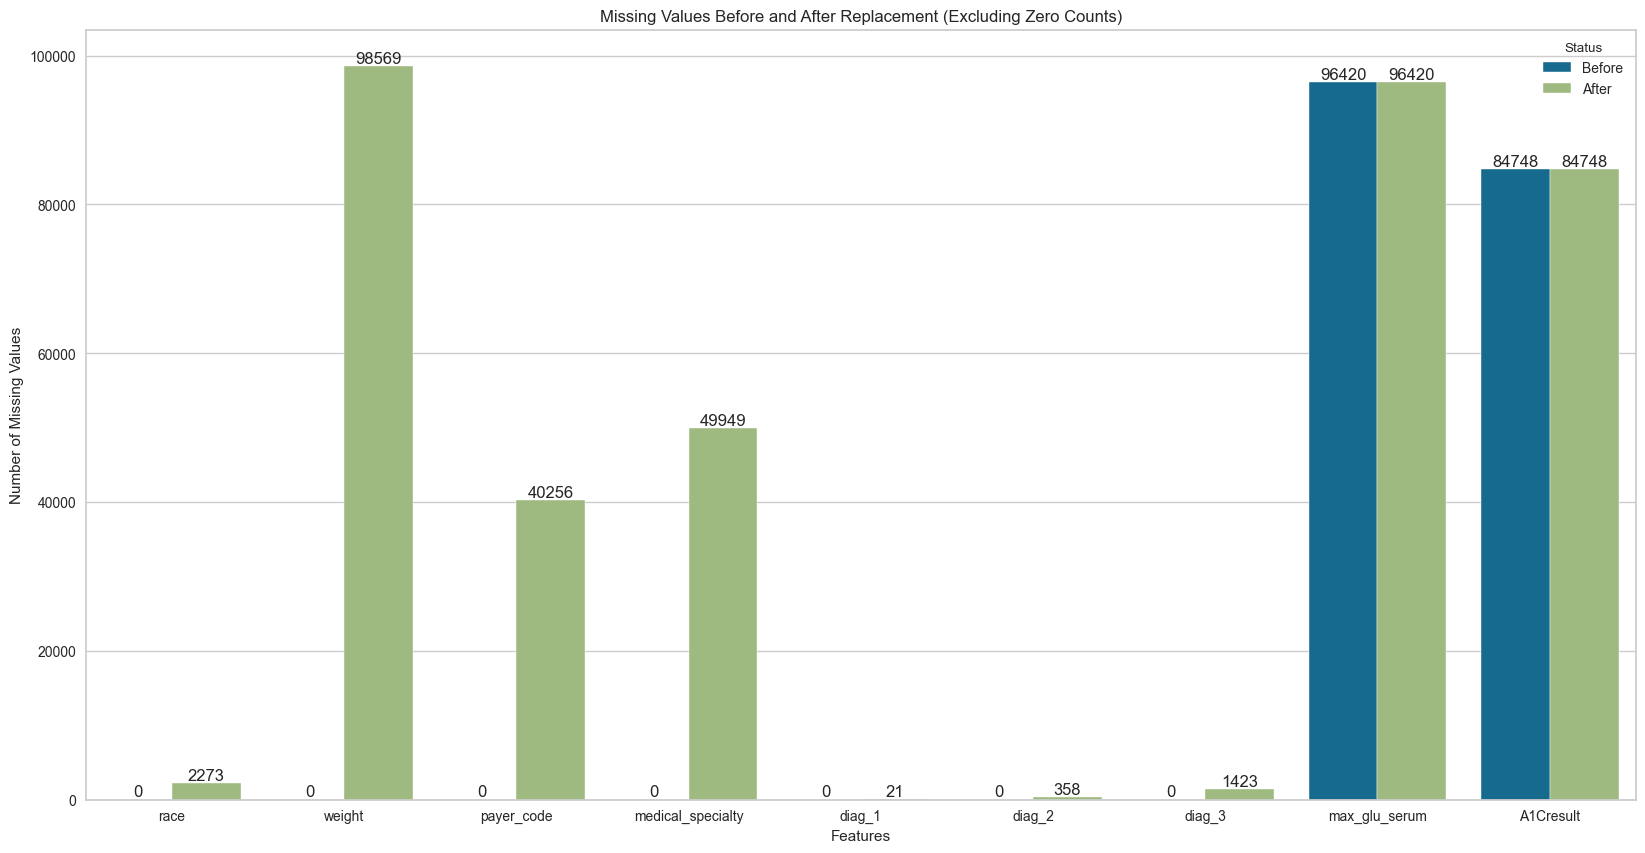

In [617]:
# Create a DataFrame directly from the counts, filtering non-zero entries
missing_summary = pd.DataFrame({'Before': missing_values_before, 'After': missing_values_after})
missing_summary = missing_summary[(missing_summary['Before'] > 0) | (missing_summary['After'] > 0)].reset_index()

# Plot
plt.figure(figsize=(20, 10))
ax = sns.barplot(x='index', y='value', hue='variable', data=pd.melt(missing_summary, id_vars='index'))
plt.xlabel('Features')
plt.ylabel('Number of Missing Values')
plt.title('Missing Values Before and After Replacement (Excluding Zero Counts)')
plt.legend(title='Status')

# Label the bars with their respective values
for container in ax.containers:
    ax.bar_label(container)

plt.show()

### Making the 'readmitted' response variable binary

In [618]:
diabetes_curated['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0}, inplace = True)
# <30 means patient was readmitted in less than 30 days
# >30 means patient was readmitted in more than 30 days
# NO means there is no record of the patient being readmitted

In [619]:
print(diabetes_curated['readmitted'].unique())

[0 1]


In [620]:
diabetes_curated.head()

patient_nbr             race  gender      age weight  admission_type_id  \
0      8222157        Caucasian  Female   [0-10)    NaN                  6   
1     55629189        Caucasian  Female  [10-20)    NaN                  1   
2     86047875  AfricanAmerican  Female  [20-30)    NaN                  1   
3     82442376        Caucasian    Male  [30-40)    NaN                  1   
4     42519267        Caucasian    Male  [40-50)    NaN                  1   

   discharge_disposition_id  admission_source_id  time_in_hospital payer_code  \
0                        25                    1                 1        NaN   
1                         1                    7                 3        NaN   
2                         1                    7                 2        NaN   
3                         1                    7                 2        NaN   
4                         1                    7                 1        NaN   

          medical_specialty  num_lab_procedures  num_procedures  \
0  Pediatrics-Endocrinology                  41               0   
1                       NaN                  59               0   
2                       NaN                  11               5   
3                       NaN                  44               1   
4                       NaN                  51               0   

   num_medications  number_outpatient  number_emergency  number_inpatient  \
0                1                  0                 0                 0   
1               18                  0                 0                 0   
2               13                  2                 0                 1   
3               16                  0                 0                 0   
4                8                  0                 0                 0   

   diag_1  diag_2 diag_3  number_diagnoses max_glu_serum A1Cresult metformin  \
0  250.83     NaN    NaN                 1           NaN       NaN        No   
1     276  250.01    255                 9           NaN       NaN        No   
2     648     250    V27                 6           NaN       NaN        No   
3       8  250.43    403                 7           NaN       NaN        No   
4     197     157    250                 5           NaN       NaN        No   

  repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide  \
0          No          No             No          No            No        No   
1          No          No             No          No            No        No   
2          No          No             No          No            No    Steady   
3          No          No             No          No            No        No   
4          No          No             No          No            No    Steady   

  glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol  \
0        No          No           No            No       No       No   
1        No          No           No            No       No       No   
2        No          No           No            No       No       No   
3        No          No           No            No       No       No   
4        No          No           No            No       No       No   

  troglitazone tolazamide examide citoglipton insulin glyburide-metformin  \
0           No         No      No          No      No                  No   
1           No         No      No          No      Up                  No   
2           No         No      No          No      No                  No   
3           No         No      No          No      Up                  No   
4           No         No      No          No  Steady                  No   

  glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone  \
0                  No                       No                      No   
1                  No                       No                      No   
2                  No                       No                      No   
3                  No      

### Showing the different data types for each column in the dataframe

In [621]:
diabetes_curated.dtypes

patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide       

### Calculating the percentage of missing values in each column

In [622]:
missing_percentages = diabetes_curated.isna().mean() * 100
missing_percentages

patient_nbr                  0.000000
race                         2.233555
gender                       0.000000
age                          0.000000
weight                      96.858479
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
payer_code                  39.557416
medical_specialty           49.082208
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
diag_1                       0.020636
diag_2                       0.351787
diag_3                       1.398306
number_diagnoses             0.000000
max_glu_serum               94.746772
A1Cresult                   83.277322
metformin                    0.000000
repaglinide                  0.000000
nateglinide                  0.000000
chlorpropami

### Droping columns with more than 90% missing values

In [623]:
diabetes_curated = diabetes_curated.loc[:, missing_percentages < 90]
diabetes_curated.isna().mean() * 100

patient_nbr                  0.000000
race                         2.233555
gender                       0.000000
age                          0.000000
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
payer_code                  39.557416
medical_specialty           49.082208
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
diag_1                       0.020636
diag_2                       0.351787
diag_3                       1.398306
number_diagnoses             0.000000
A1Cresult                   83.277322
metformin                    0.000000
repaglinide                  0.000000
nateglinide                  0.000000
chlorpropamide               0.000000
glimepiride                  0.000000
acetohexamid

### Identifying and deleting the columns that have no variation


In [624]:
# Identifying near-zero variance columns
# Columns where the most frequent value accounts for 95% or more (after rounding to 2 decimal places) will be considered as near-zero variance
threshold = 0.95
near_zero_var_columns = diabetes_curated.columns[diabetes_curated.apply(lambda x: round(x.value_counts(normalize=True).iloc[0], 2) >= threshold)]

# Deleting the identified near-zero variance columns from the DataFrame
diabetes_curated.drop(columns=near_zero_var_columns, inplace=True)

print("Near-zero variance columns deleted:", near_zero_var_columns.tolist())

Near-zero variance columns deleted: ['repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']


In [625]:
diabetes_curated.head()

patient_nbr             race  gender      age  admission_type_id  \
0      8222157        Caucasian  Female   [0-10)                  6   
1     55629189        Caucasian  Female  [10-20)                  1   
2     86047875  AfricanAmerican  Female  [20-30)                  1   
3     82442376        Caucasian    Male  [30-40)                  1   
4     42519267        Caucasian    Male  [40-50)                  1   

   discharge_disposition_id  admission_source_id  time_in_hospital payer_code  \
0                        25                    1                 1        NaN   
1                         1                    7                 3        NaN   
2                         1                    7                 2        NaN   
3                         1                    7                 2        NaN   
4                         1                    7                 1        NaN   

          medical_specialty  num_lab_procedures  num_procedures  \
0  Pediatrics-Endocrinology                  41               0   
1                       NaN                  59               0   
2                       NaN                  11               5   
3                       NaN                  44               1   
4                       NaN                  51               0   

   num_medications  number_outpatient  number_emergency  number_inpatient  \
0                1                  0                 0                 0   
1               18                  0                 0                 0   
2               13                  2                 0                 1   
3               16                  0                 0                 0   
4                8                  0                 0                 0   

   diag_1  diag_2 diag_3  number_diagnoses A1Cresult metformin glipizide  \
0  250.83     NaN    NaN                 1       NaN        No        No   
1     276  250.01    255                 9       NaN        No        No   
2     648     250    V27                 6       NaN        No    Steady   
3       8  250.43    403                 7       NaN        No        No   
4     197     157    250                 5       NaN        No    Steady   

  glyburide pioglitazone rosiglitazone insulin change diabetesMed  readmitted  
0        No           No            No      No     No          No           0  
1        No           No            No      Up     Ch         Yes           0  
2        No           No            No      No     No         Yes           0  
3        No           No            No      Up     Ch         Yes           0  
4        No           No            No  Steady     Ch         Yes           0

### Deleting the rows that have NaN values

In [626]:
# Drop rows with any column having NaN/null
diabetes_curated.dropna(inplace = True)

In [627]:
diabetes_curated.head()

patient_nbr             race  gender      age  admission_type_id  \
23879      7239654        Caucasian  Female  [70-80)                  1   
24069     14244093        Caucasian  Female  [30-40)                  1   
24117       537543        Caucasian  Female  [30-40)                  2   
24177       354474        Caucasian    Male  [70-80)                  2   
24228      1186533  AfricanAmerican  Female  [30-40)                  1   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
23879                         3                    6                12   
24069                         1                    6                13   
24117                         1                    4                11   
24177                         3                    1                12   
24228                         1                    6                 6   

      payer_code medical_specialty  num_lab_procedures  num_procedures  \
23879         UN  InternalMedicine                  77               5   
24069         MC        Nephrology                  75               2   
24117         MC        Nephrology                  43               5   
24177         MC  InternalMedicine                  68               1   
24228         HM  InternalMedicine                  50               2   

       num_medications  number_outpatient  number_emergency  number_inpatient  \
23879               19                  0                 0                 0   
24069               16                  0                 0                 0   
24117               16                  0                 0                 0   
24177               20                  0                 0                 0   
24228                9                  0                 0                 0   

      diag_1  diag_2  diag_3  number_diagnoses A1Cresult metformin glipizide  \
23879    238  250.02     733                 5        >8        No        No   
24069    112     996  250.13                 5        >8        No        No   
24117    996      38     403                 5        >8        No        No   
24177    348     427  250.92                 5        >7        No      Down   
24228    614     569     493                 5      Norm        No        No   

      glyburide pioglitazone rosiglitazone insulin change diabetesMed  \
23879        No           No            No  Steady     No         Yes   
24069        No           No            No  Steady     No         Yes   
24117        No       Steady            No  Steady     Ch         Yes   
24177        No           No            No      No     Ch         Yes   
24228        No           No            No      No     No          No   

       readmitted  
23879           0  
24069           0  
24117           0  
24177           0  
24228           0

### Showing the summary statistics of the numerical columns

In [628]:
# summary statistics of the dataframe
print(diabetes_curated.describe())

        patient_nbr  admission_type_id  discharge_disposition_id  \
count  4.166000e+03        4166.000000               4166.000000   
mean   6.124034e+07           1.833413                  2.697312   
std    3.936169e+07           0.753764                  4.024514   
min    7.290000e+02           1.000000                  1.000000   
25%    2.480188e+07           1.000000                  1.000000   
50%    5.984079e+07           2.000000                  1.000000   
75%    9.483692e+07           2.000000                  3.000000   
max    1.886349e+08           6.000000                 28.000000   

       admission_source_id  time_in_hospital  num_lab_procedures  \
count          4166.000000       4166.000000         4166.000000   
mean              5.148104          4.944311           53.853577   
std               2.673494          3.107173           16.695628   
min               1.000000          1.000000            1.000000   
25%               1.000000          3.000000   

### Visualising the summary statistics of the relevant numerical columns through a boxplot

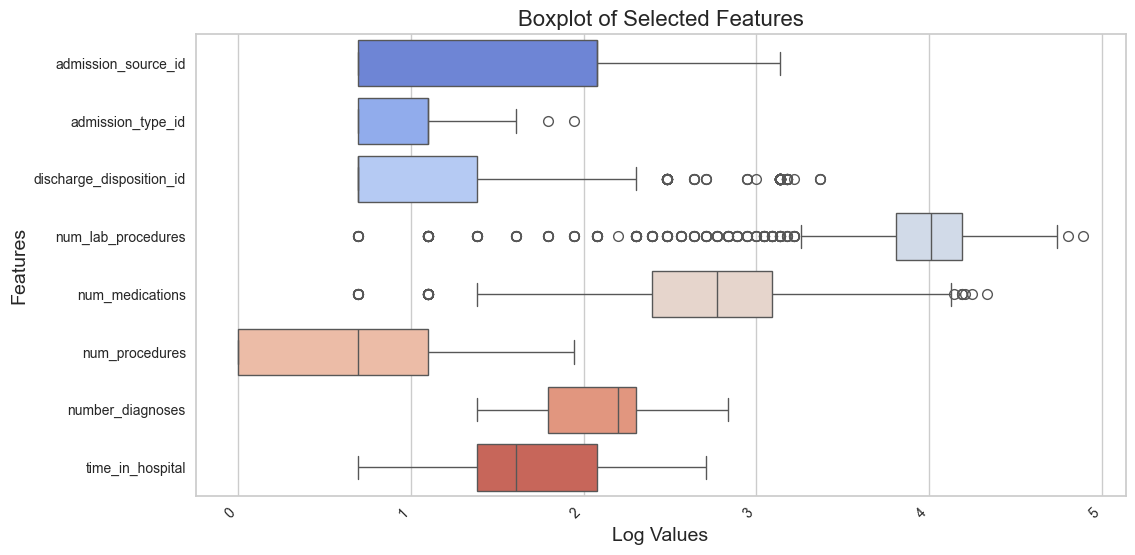

In [629]:
# Select numerical columns excluding 'patient_nbr', 'number_outpatient', 'number_emergency', 'number_inpatient', and 'readmitted'
numerical_columns = diabetes_curated.select_dtypes(include=['float64', 'int64']).columns
columns_to_exclude = ['patient_nbr', 'number_outpatient', 'number_emergency', 'number_inpatient', 'readmitted']
numerical_columns = numerical_columns.difference(columns_to_exclude)

# Create a temporary DataFrame for boxplot visualization
temp_df = diabetes_curated[numerical_columns].copy()

# Applying log transformation to selected numerical columns in the temporary DataFrame
for column in numerical_columns:
    # Add a small positive value to handle zero values
    temp_df[column] = np.log(temp_df[column] + 1)

# Set the style of seaborn for better aesthetics
sns.set_style("whitegrid")

# Create the boxplot with the updated size and aspect ratio
plt.figure(figsize=(12, 6))

# Plotting the boxplot with seaborn using the temporary DataFrame
ax = sns.boxplot(data=temp_df, orient='h', palette="coolwarm")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
ax.set_xlabel('Log Values', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
ax.set_title('Boxplot of Selected Features', fontsize=16)
plt.show()

### Identifying the outliers and dropping them from the data

In [630]:
# Loop through each numeric column in the dataframe
outlier_indices = set()
for column in numerical_columns:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile) of the column
    Q1 = diabetes_curated[column].quantile(0.25)
    Q3 = diabetes_curated[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define outliers as those that are below (Q1 - 1.5 * IQR) or above (Q3 + 1.5 * IQR)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Get the indices of outliers and add them to the set
    outlier_indices.update(diabetes_curated[(diabetes_curated[column] < lower_bound) | (diabetes_curated[column] > upper_bound)].index)

# Show the shape before and after dropping outliers
print(f"DataFrame shape before removing outliers: {diabetes_curated.shape}")
diabetes_curated.drop(index=outlier_indices, inplace=True)
print(f"New DataFrame shape after removing outliers: {diabetes_curated.shape}")
diabetes_curated['readmitted'].value_counts()

DataFrame shape before removing outliers: (4166, 30)
New DataFrame shape after removing outliers: (3593, 30)


readmitted
0    3257
1     336
Name: count, dtype: int64

### Showing the stats of the data to determine if normalisation is required

In [631]:
print("Summary statistics before normalization:")
diabetes_curated.describe()

Summary statistics before normalization:


patient_nbr  admission_type_id  discharge_disposition_id  \
count  3.593000e+03        3593.000000               3593.000000   
mean   6.024091e+07           1.809630                  1.898414   
std    3.948966e+07           0.736759                  1.615791   
min    7.290000e+02           1.000000                  1.000000   
25%    2.421756e+07           1.000000                  1.000000   
50%    5.670796e+07           2.000000                  1.000000   
75%    9.474906e+07           2.000000                  3.000000   
max    1.886349e+08           3.000000                  6.000000   

       admission_source_id  time_in_hospital  num_lab_procedures  \
count          3593.000000       3593.000000         3593.000000   
mean              5.191205          4.738380           54.373504   
std               2.625770          2.854395           14.610027   
min               1.000000          1.000000           13.000000   
25%               1.000000          3.000000           44.000000   
50%               7.000000          4.000000           54.000000   
75%               7.000000          6.000000           65.000000   
max              10.000000         13.000000           96.000000   

       num_procedures  num_medications  number_outpatient  number_emergency  \
count     3593.000000      3593.000000        3593.000000       3593.000000   
mean         1.029502        15.315892           0.190927          0.279711   
std          1.368073         6.934157           0.818601          1.085423   
min          0.000000         1.000000           0.000000          0.000000   
25%          0.000000        10.000000           0.000000          0.000000   
50%          0.000000        14.000000           0.000000          0.000000   
75%          2.000000        20.000000           0.000000          0.000000   
max          5.000000        37.000000          13.000000         18.000000   

       number_inpatient  number_diagnoses   readmitted  
count       3593.000000       3593.000000  3593.000000  
mean           0.464793          7.236571     0.093515  
std            1.131867          1.935551     0.291194  
min            0.000000          3.000000     0.000000  
25%            0.000000          5.000000     0.000000  
50%            0.000000          8.000000     0.000000  
75%            1.000000          9.000000     0.000000  
max           12.000000         14.000000     1.000000

Based on the summary statistics, The presence of different scales suggests that normalization is beneficial to bring all features to a similar scale before further analysis or modeling.

### Applying standard scalar normalisation to the data

In [632]:
# Normalize numeric features using StandardScaler
scaler = StandardScaler()
numeric_features = diabetes_curated.select_dtypes(include=[np.number]).columns.drop('readmitted')
diabetes_normalised = diabetes_curated.copy()
diabetes_normalised[numeric_features] = scaler.fit_transform(diabetes_curated[numeric_features])

print("\nSummary statistics after normalization:")
diabetes_normalised.describe()


Summary statistics after normalization:


patient_nbr  admission_type_id  discharge_disposition_id  \
count  3.593000e+03       3.593000e+03              3.593000e+03   
mean   6.328240e-17      -9.492361e-17             -1.582060e-17   
std    1.000139e+00       1.000139e+00              1.000139e+00   
min   -1.525680e+00      -1.099060e+00             -5.560984e-01   
25%   -9.123494e-01      -1.099060e+00             -5.560984e-01   
50%   -8.947754e-02       2.584246e-01             -5.560984e-01   
75%    8.739744e-01       2.584246e-01              6.818579e-01   
max    3.251784e+00       1.615910e+00              2.538792e+00   

       admission_source_id  time_in_hospital  num_lab_procedures  \
count         3.593000e+03      3.593000e+03        3.593000e+03   
mean          1.107442e-16      3.164120e-17       -3.955150e-17   
std           1.000139e+00      1.000139e+00        1.000139e+00   
min          -1.596404e+00     -1.309875e+00       -2.832251e+00   
25%          -1.596404e+00     -6.091035e-01       -7.101252e-01   
50%           6.889586e-01     -2.587178e-01       -2.556847e-02   
75%           6.889586e-01      4.420535e-01        7.274439e-01   
max           1.831640e+00      2.894753e+00        2.849570e+00   

       num_procedures  num_medications  number_outpatient  number_emergency  \
count    3.593000e+03     3.593000e+03       3.593000e+03      3.593000e+03   
mean    -1.235984e-16     1.265648e-16      -1.582060e-17      3.164120e-17   
std      1.000139e+00     1.000139e+00       1.000139e+00      1.000139e+00   
min     -7.526244e-01    -2.064834e+00      -2.332681e-01     -2.577331e-01   
25%     -7.526244e-01    -7.667308e-01      -2.332681e-01     -2.577331e-01   
50%     -7.526244e-01    -1.897960e-01      -2.332681e-01     -2.577331e-01   
75%      7.094894e-01     6.756063e-01      -2.332681e-01     -2.577331e-01   
max      2.902660e+00     3.127579e+00       1.564970e+01      1.632797e+01   

       number_inpatient  number_diagnoses   readmitted  
count      3.593000e+03      3.593000e+03  3593.000000  
mean      -2.373090e-17      3.164120e-17     0.093515  
std        1.000139e+00      1.000139e+00     0.291194  
min       -4.106995e-01     -2.189124e+00     0.000000  
25%       -4.106995e-01     -1.155683e+00     0.000000  
50%       -4.106995e-01      3.944795e-01     0.000000  
75%        4.729192e-01      9.112002e-01     0.000000  
max        1.019273e+01      3.494804e+00     1.000000

### Showing the shape of the final cleaned dataframe

In [633]:
diabetes_normalised.shape

(3593, 30)

In [634]:
diabetes_normalised

patient_nbr             race  gender      age  admission_type_id  \
23879     -1.342342        Caucasian  Female  [70-80)          -1.099060   
24069     -1.164944        Caucasian  Female  [30-40)          -1.099060   
24117     -1.512084        Caucasian  Female  [30-40)           0.258425   
24177     -1.516720        Caucasian    Male  [70-80)           0.258425   
24228     -1.495647  AfricanAmerican  Female  [30-40)          -1.099060   
...             ...              ...     ...      ...                ...   
101688    -0.645549        Caucasian    Male  [20-30)          -1.099060   
101695    -0.638069        Caucasian    Male  [60-70)           0.258425   
101720     3.037898        Caucasian    Male  [50-60)           0.258425   
101735     1.173997        Caucasian    Male  [70-80)           0.258425   
101749     1.168861        Caucasian  Female  [70-80)           1.615910   

        discharge_disposition_id  admission_source_id  time_in_hospital  \
23879                   0.681858             0.308065          2.544368   
24069                  -0.556098             0.308065          2.894753   
24117                  -0.556098            -0.453723          2.193982   
24177                   0.681858            -1.596404          2.544368   
24228                  -0.556098             0.308065          0.442054   
...                          ...                  ...               ...   
101688                 -0.556098             0.688959         -0.258718   
101695                  0.062880             0.688959         -0.258718   
101720                 -0.556098             0.688959          0.091668   
101735                  2.538792             0.688959          0.442054   
101749                  2.538792            -1.596404         -0.609104   

       payer_code       medical_specialty  num_lab_procedures  num_procedures  \
23879          UN        InternalMedicine            1.548912        2.902660   
24069          MC              Nephrology            1.412001        0.709489   
24117          MC              Nephrology           -0.778581        2.902660   
24177          MC        InternalMedicine            0.932811       -0.021568   
24228          HM        InternalMedicine           -0.299391        0.709489   
...           ...                     ...                 ...             ...   
101688         SP        Emergency/Trauma            2.096557       -0.752624   
101695         CM        Emergency/Trauma            0.658988        2.171603   
101720         BC  Family/GeneralPractice            1.138178        2.902660   
101735         MC        Emergency/Trauma           -0.573214        2.902660   
101749         MC             Orthopedics           -1.873872       -0.021568   

        num_medications  number_outpatient  number_emergency  \
23879          0.531373          -0.233268         -0.257733   
24069          0.098671          -0.233268         -0.257733   
24117          0.098671          -0.233268         -0.257733   
24177          0.675606          -0.233268         -0.257733   
24228         -0.910965          -0.233268         -0.257733   
...                 ...                ...               ...   
101688        -0.045562          -0.233268         -0.257733   
101695         1.108307          -0.233268         -0.257733   
101720         1.108307          -0.233268         -0.257733   
101735        -0.189796          -0.233268         -0.257733   
101749         1.973710          -0.233268          0.663695   

        number_inpatient  diag_1  diag_2  diag_3  number_diagnoses A1Cresult  \
23879          -0.410699     238  250.02     733         -1.155683        >8   
24069          -0.410699     112     996  250.13         -1.155683        >8   
24117          -0.410699     996      38     403         -1.155683        >8   
24177          -0.410699     348     427  250.92         -1.155683        >7   
24228          -0.410699     614     569     493    

# 2. Data Visualisation

## Plotting the distribution of unique classes of the target variable (readmitted).

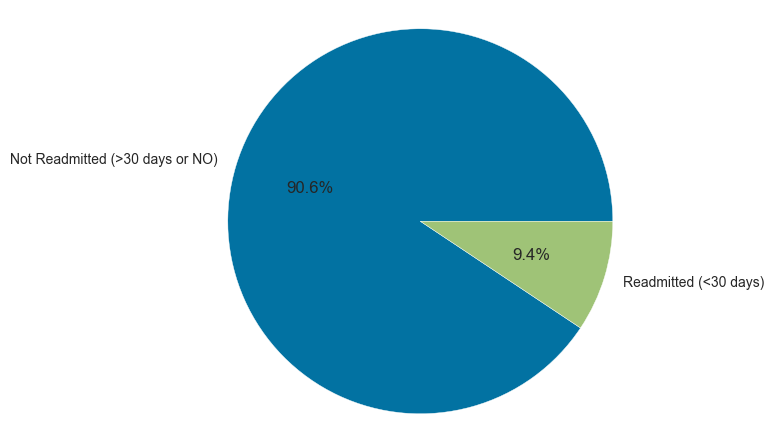

In [635]:
counts = diabetes_normalised['readmitted'].value_counts()

# Labels for the pie chart sections
labels = ['Not Readmitted (>30 days or NO)', 'Readmitted (<30 days)']

# Sizes for each section
sizes = [counts[0], counts[1]]

# Creating the pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')  # autopct adds percentage labels to the sections
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

# Display the pie chart
plt.show()

<Axes: xlabel='readmitted', ylabel='count'>

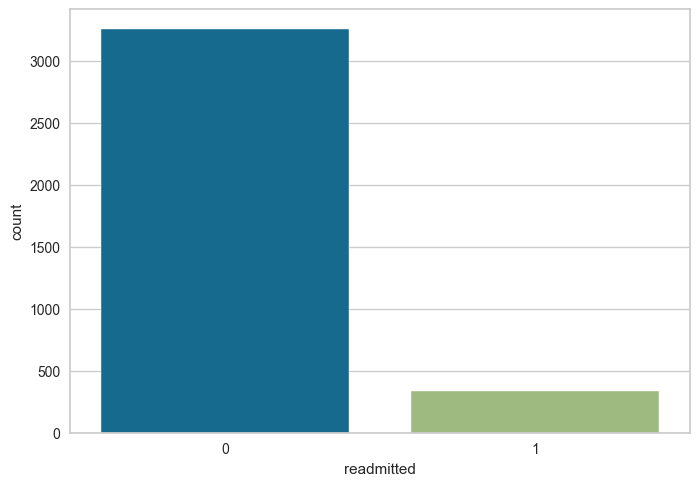

In [636]:
sns.countplot(data=diabetes_normalised, x='readmitted', hue='readmitted', legend=False)

## Plotting a graph that displays the count of target variable against the number of medications.

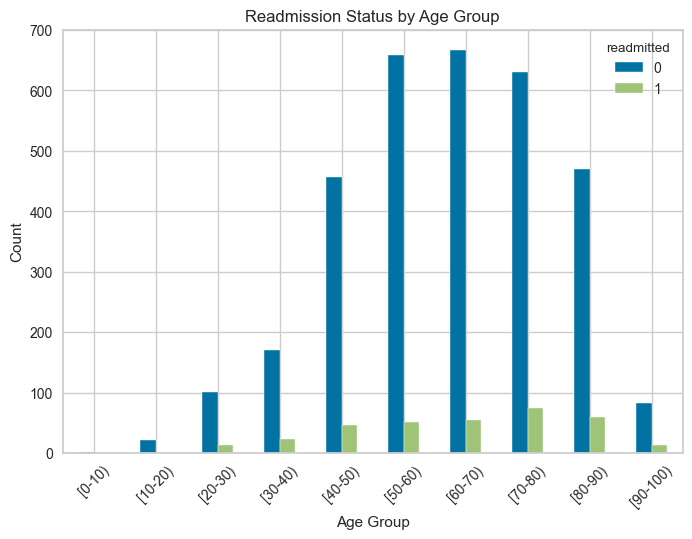

In [637]:
readmission_by_age = pd.crosstab(diabetes_curated['age'], diabetes_curated['readmitted'])
readmission_by_age.plot(kind='bar')
plt.title('Readmission Status by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

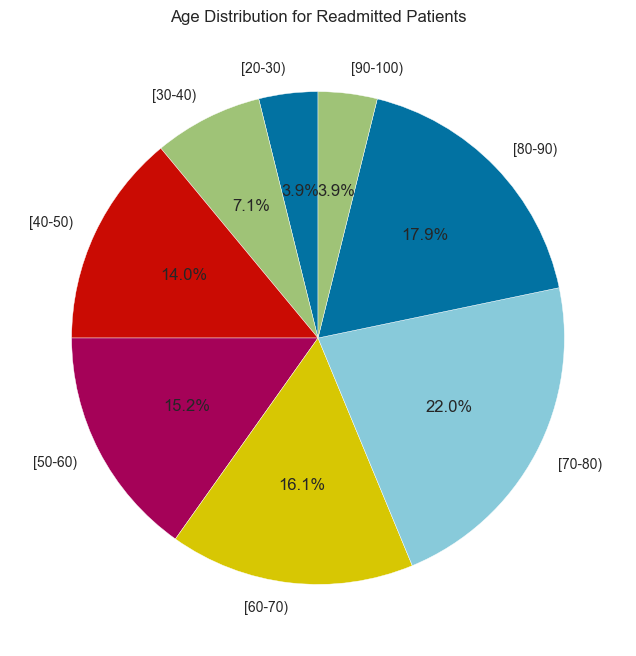

In [638]:
# Filter for readmitted patients and get 'age' column
readmitted_ages = diabetes_curated[diabetes_curated['readmitted'] == 1]['age']

# Calculate normalized value counts and sort the index
readmitted_age_counts_sorted = readmitted_ages.value_counts(normalize=True).sort_index()

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(readmitted_age_counts_sorted, labels=readmitted_age_counts_sorted.index, autopct='%1.1f%%', startangle=90)
plt.title('Age Distribution for Readmitted Patients')
plt.show()

## Graph that displays the count of target variable against the number of medications

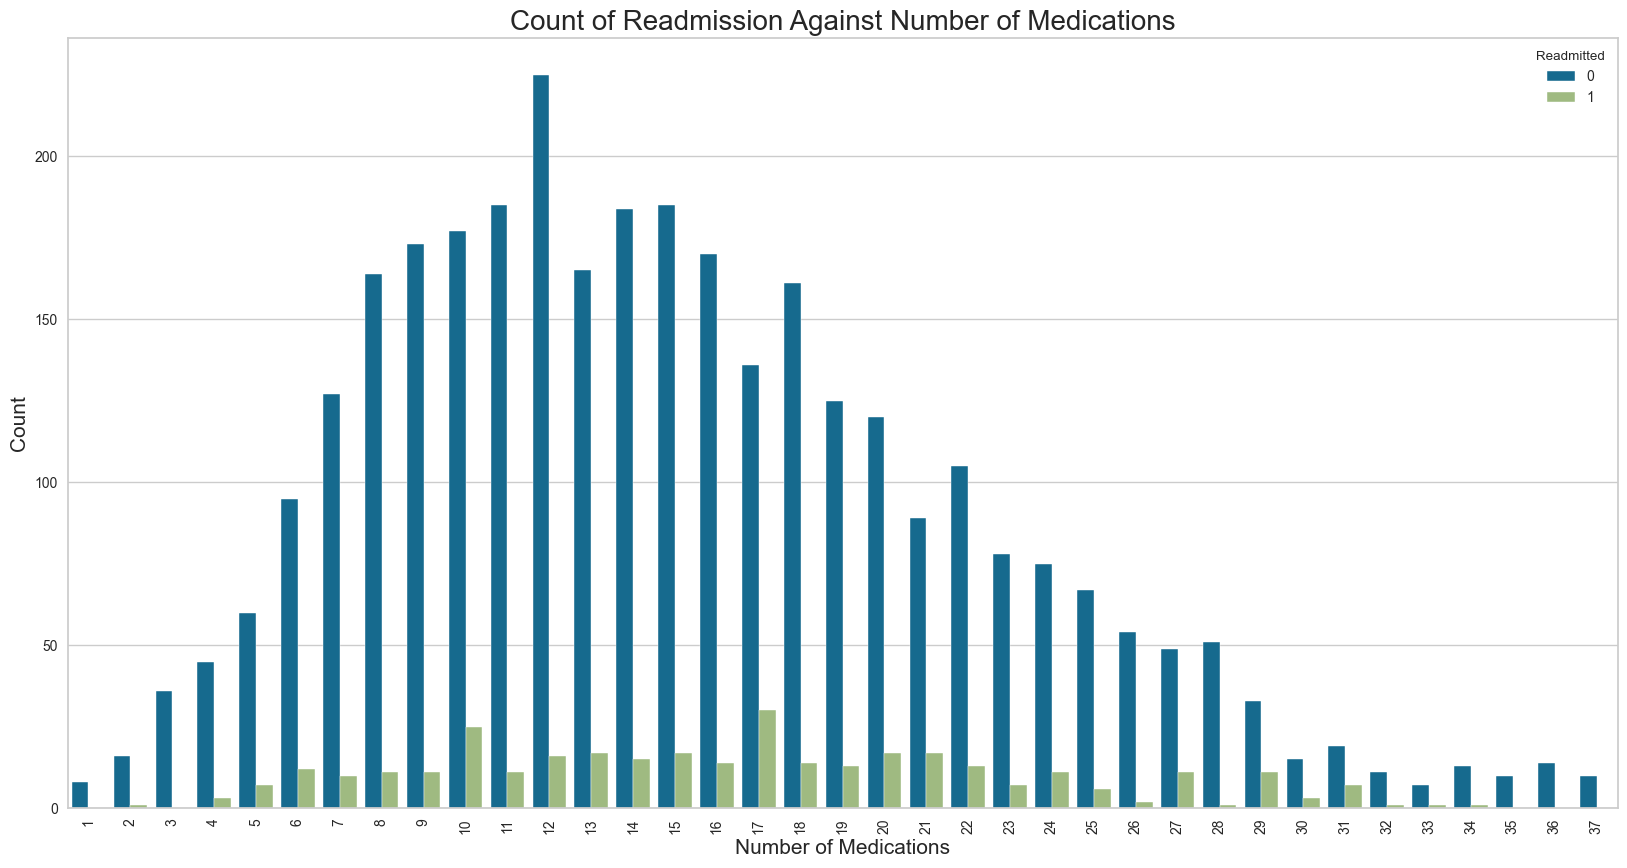

In [639]:
# We need to aggregate the data to count the instances of readmission for each number of medications
plot_data = diabetes_curated.groupby(['num_medications', 'readmitted']).size().reset_index(name='count')

# Plot the data
plt.figure(figsize=(20, 10))
sns.barplot(x='num_medications', y='count', hue='readmitted', data=plot_data)

plt.title('Count of Readmission Against Number of Medications', fontsize=20)
plt.xlabel('Number of Medications', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(rotation=90)
plt.legend(title='Readmitted')

# Show the plot
plt.show()

## The scatter matrix plot and the correlation matrix.

<Figure size 1200x1200 with 0 Axes>

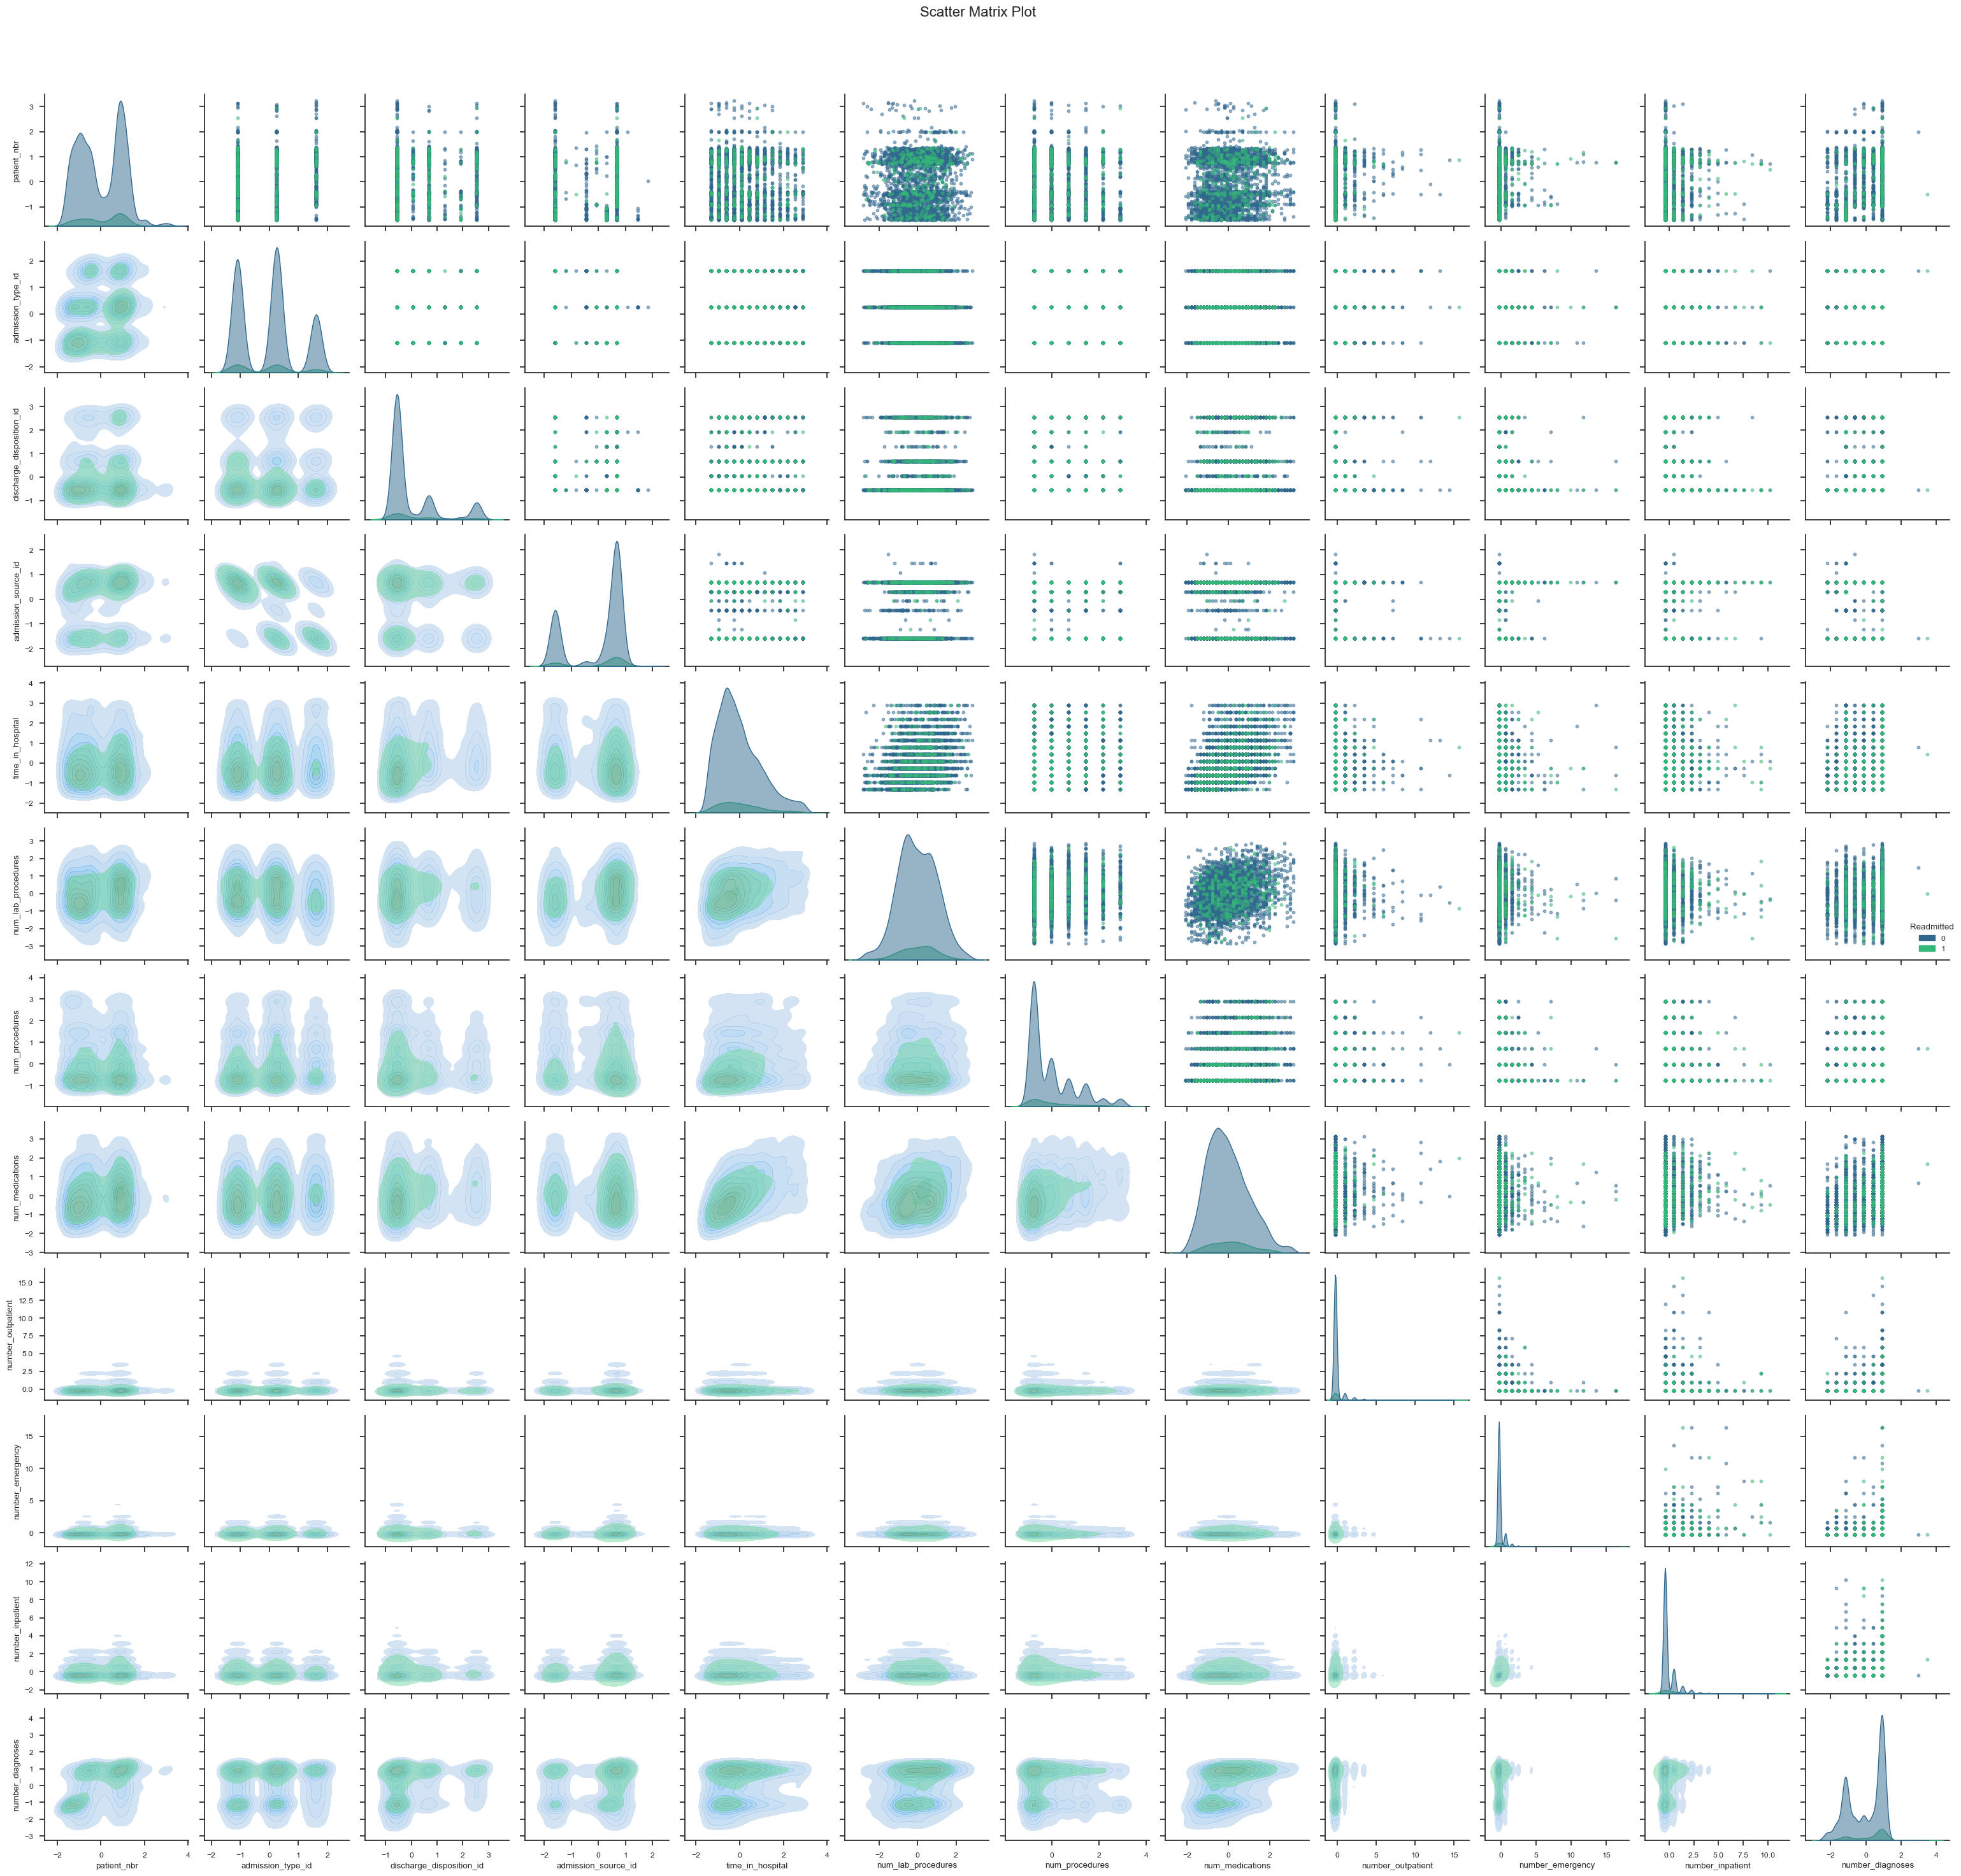

In [640]:

# Select numerical columns for the scatter matrix plot
numerical_columns = diabetes_normalised.select_dtypes(include=['float64', 'int64']).columns

# Create the scatter matrix plot
plt.figure(figsize=(12, 12))
sns.set(style="ticks", font_scale=0.8)
g = sns.PairGrid(diabetes_normalised[numerical_columns], hue='readmitted', palette='viridis', diag_sharey=False)
g.map_upper(plt.scatter, s=10, alpha=0.5)
g.map_lower(sns.kdeplot, fill=True, alpha=0.5, thresh=0.05)
g.map_diag(sns.kdeplot, fill=True, alpha=0.5)
g.add_legend(title='Readmitted')
plt.suptitle('Scatter Matrix Plot', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


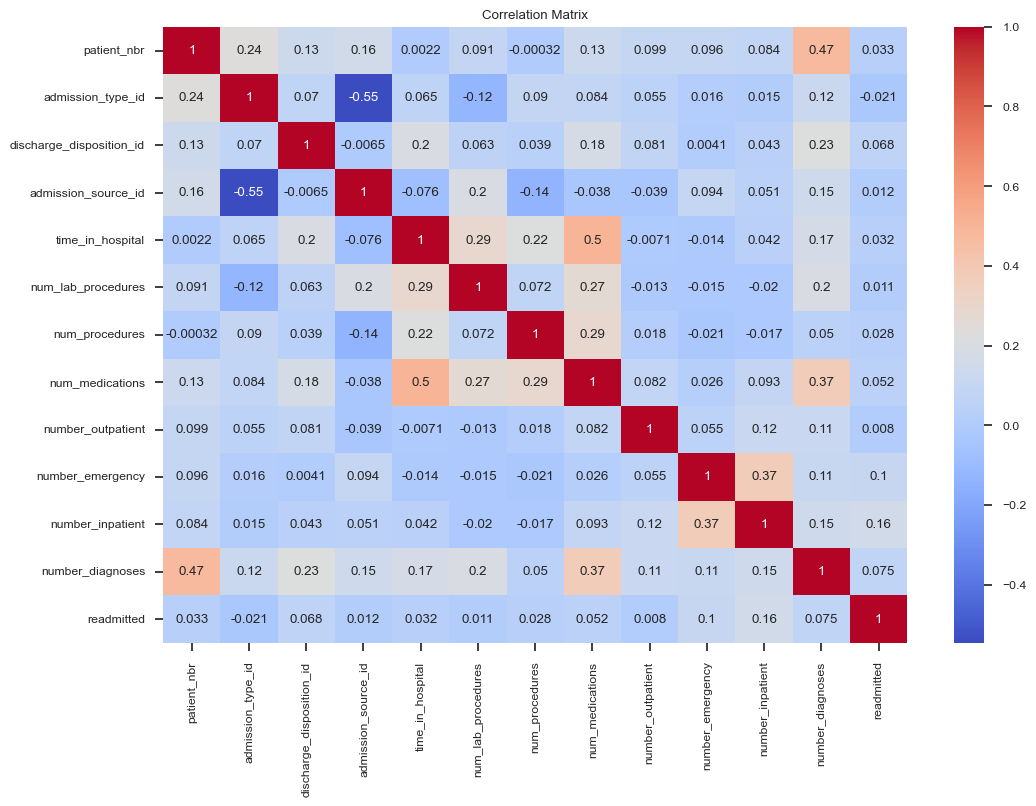

In [641]:
# Creating the correlation matrix
correlation_matrix = diabetes_curated[numerical_columns].corr()

# Calculate correlation between "readmitted" and each numerical column
readmitted_corr = []
for column in numerical_columns:
    corr = diabetes_curated['readmitted'].corr(diabetes_curated[column])
    readmitted_corr.append(corr)

# Create a new correlation matrix with "readmitted" added
readmitted_corr_series = pd.Series(readmitted_corr, index=numerical_columns)
correlation_matrix['readmitted'] = readmitted_corr_series
correlation_matrix.loc['readmitted'] = readmitted_corr_series

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Additional plots

### Distribution of Patient Characteristics by Readmission Status

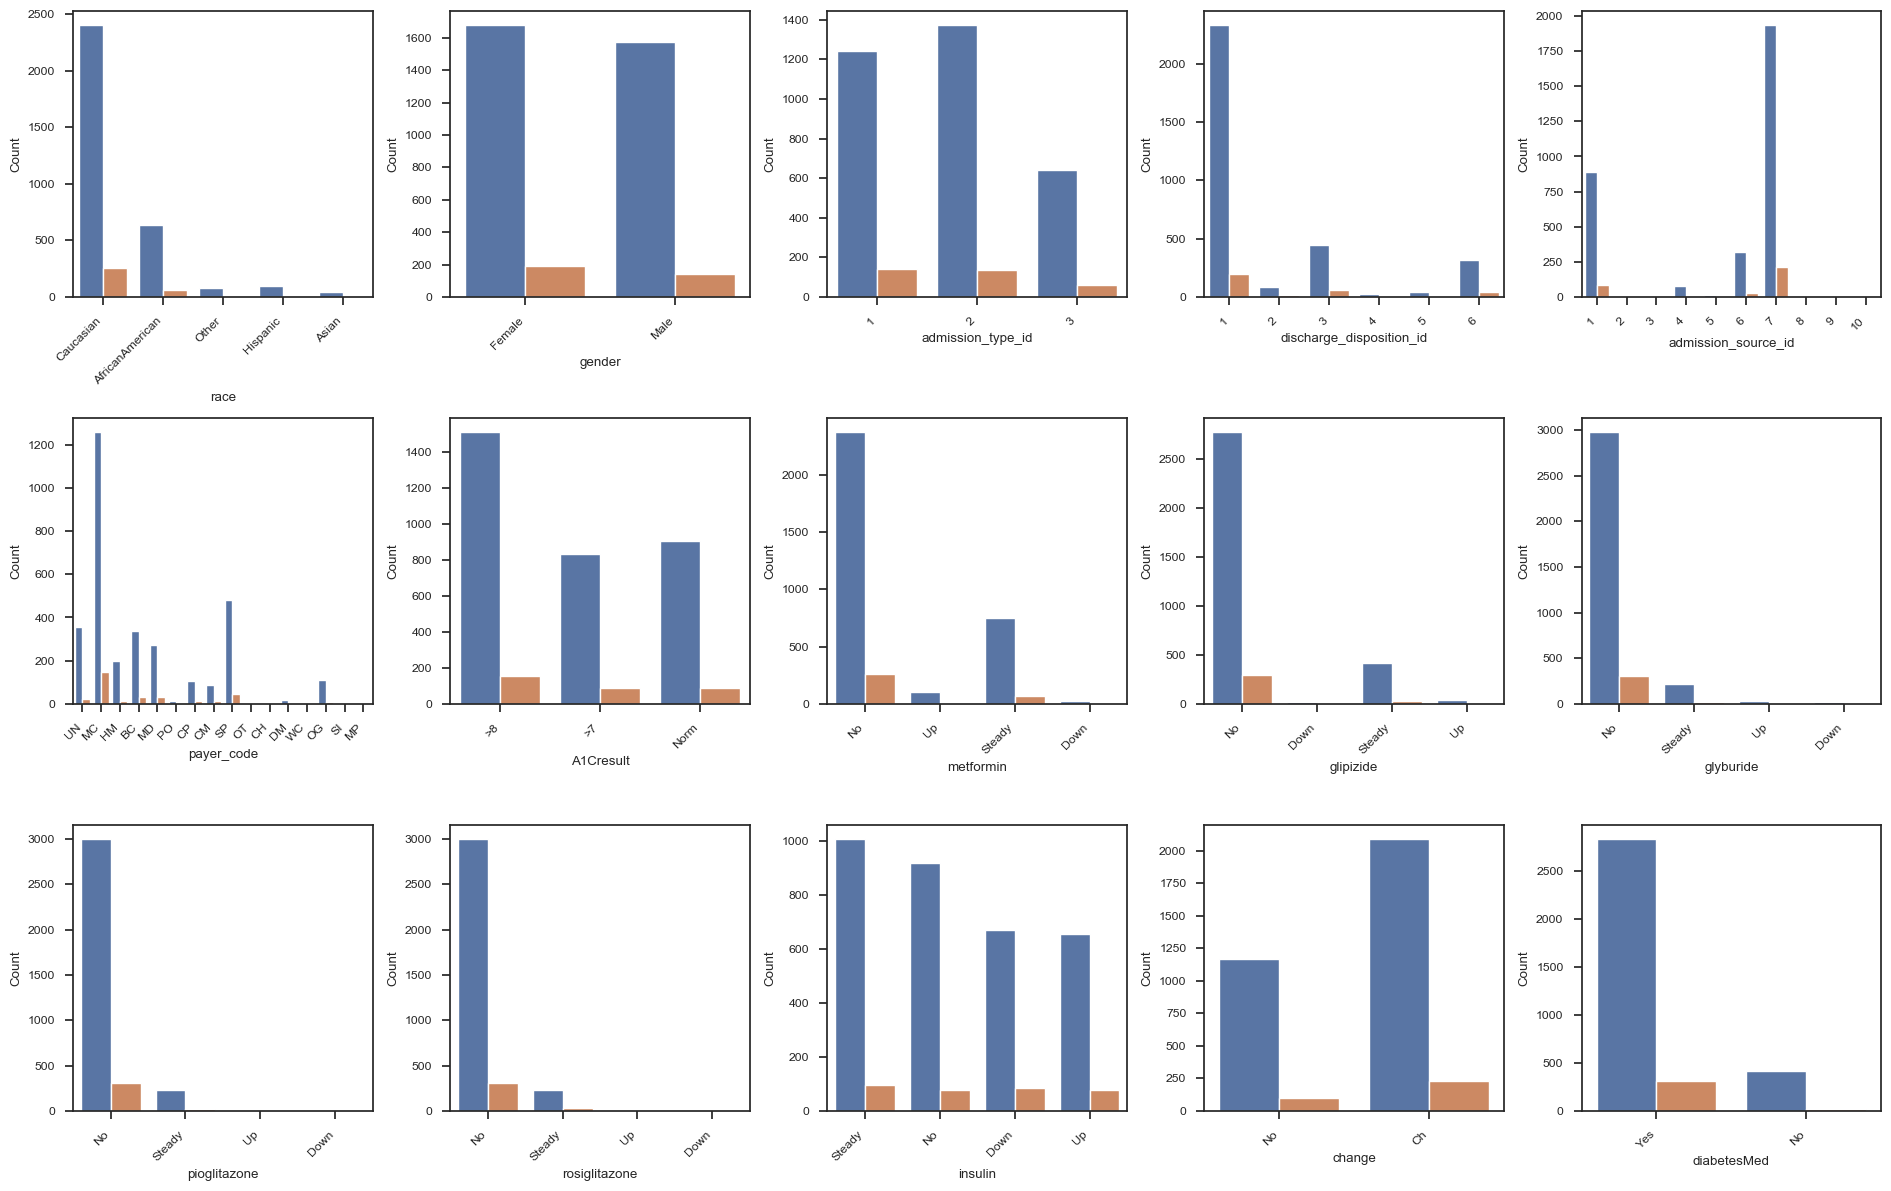

In [642]:
diabetes_countplot = diabetes_curated.copy()
diabetes_countplot['medical_specialty'] = pd.factorize(diabetes_countplot['medical_specialty'])[0] + 1

cols2 = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
         'payer_code', 'A1Cresult', 'metformin', 'glipizide', 'glyburide',
         'pioglitazone', 'rosiglitazone', 'insulin', 'change', 'diabetesMed']

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(19, 12))
axes = axes.flatten()

for i, col in enumerate(cols2):
    sns.countplot(x=col, data=diabetes_countplot, hue="readmitted", ax=axes[i], legend=False)
    axes[i].set_ylabel('Count')
    axes[i].set_xlabel(col)
    for label in axes[i].get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

plt.tight_layout()
plt.show()

### Readmission Count by Medical Specialty

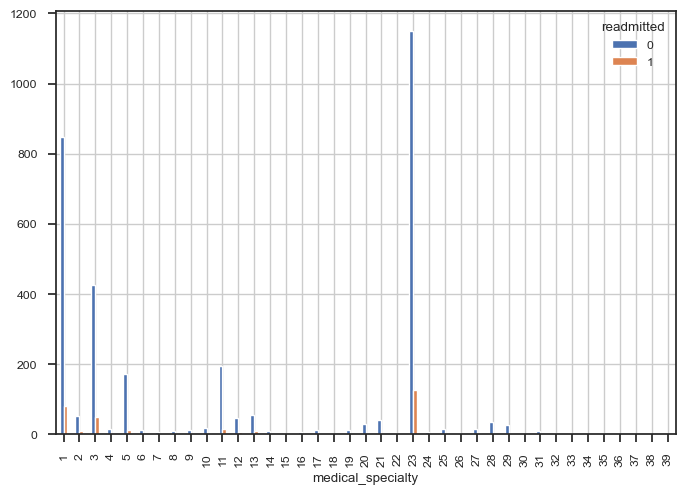

In [643]:
readmission_by_age = pd.crosstab(diabetes_countplot['medical_specialty'], diabetes_countplot['readmitted'])
readmission_by_age.plot(kind='bar')
plt.grid(True)
plt.show()

### Distribution of Patient Metrics by Readmission Status

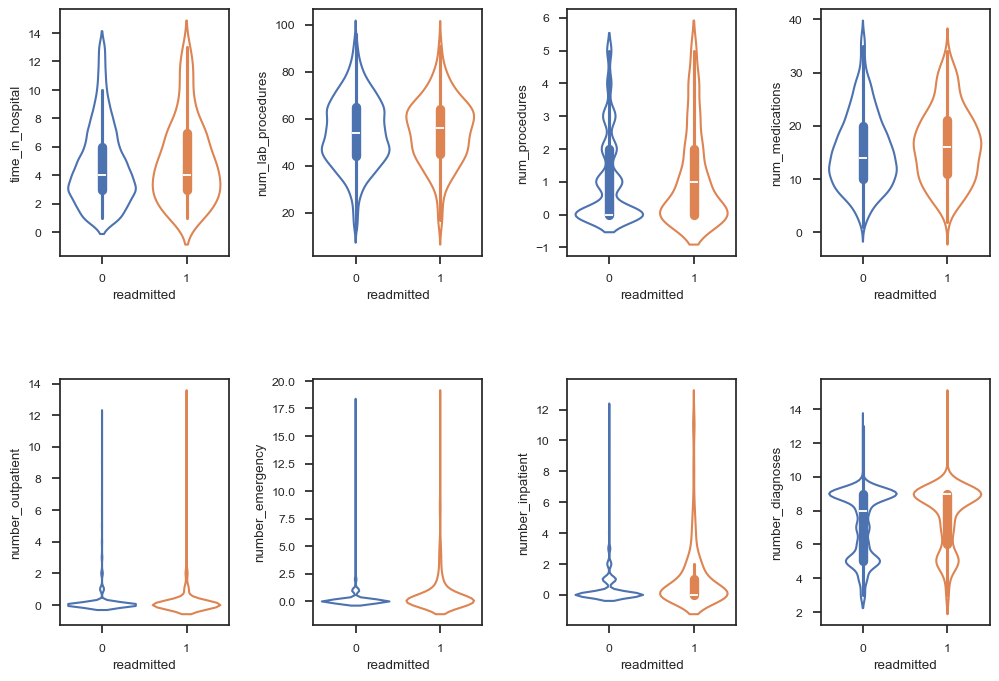

In [644]:
cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient',
        'number_emergency', 'number_inpatient', 'number_diagnoses']

nrows = 2
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    sns.violinplot(x="readmitted", y=col, data=diabetes_curated, fill=False, hue="readmitted", ax=ax,
                   legend=False)

fig.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

### Patient Characteristics vs Readmission Status

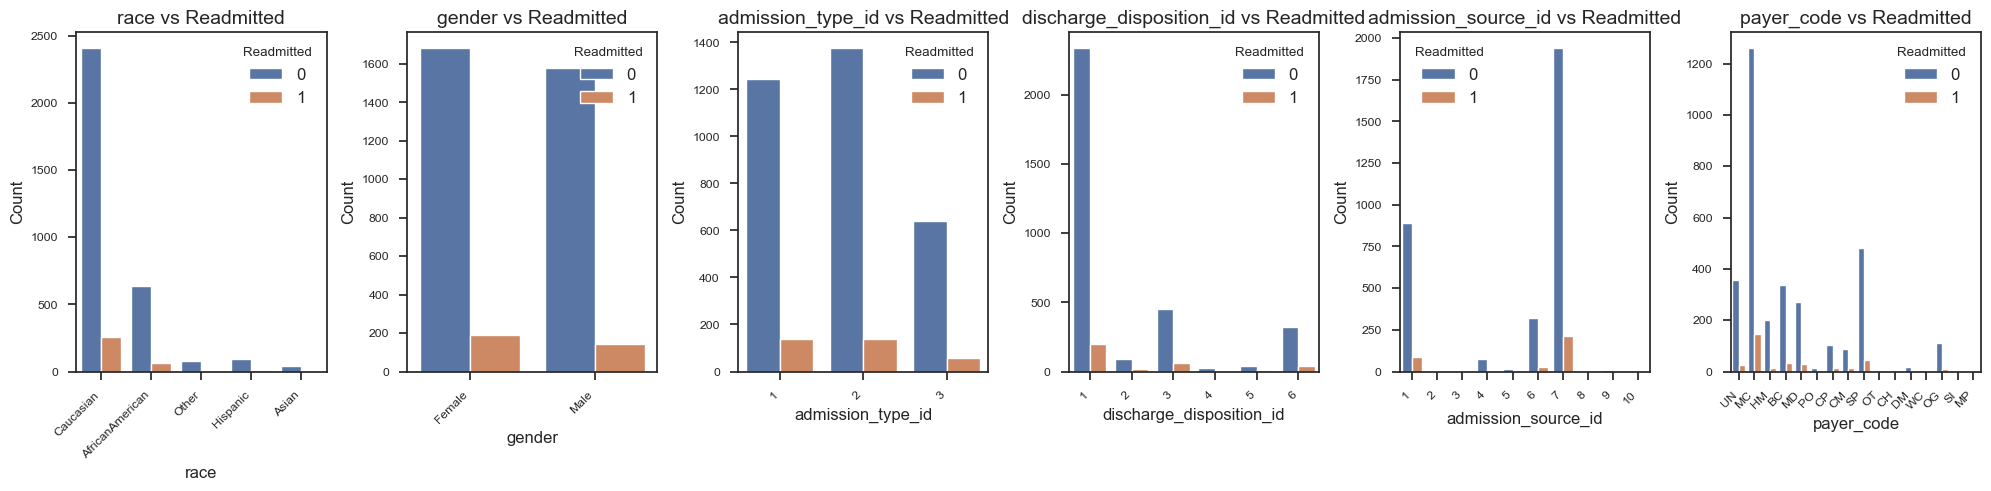

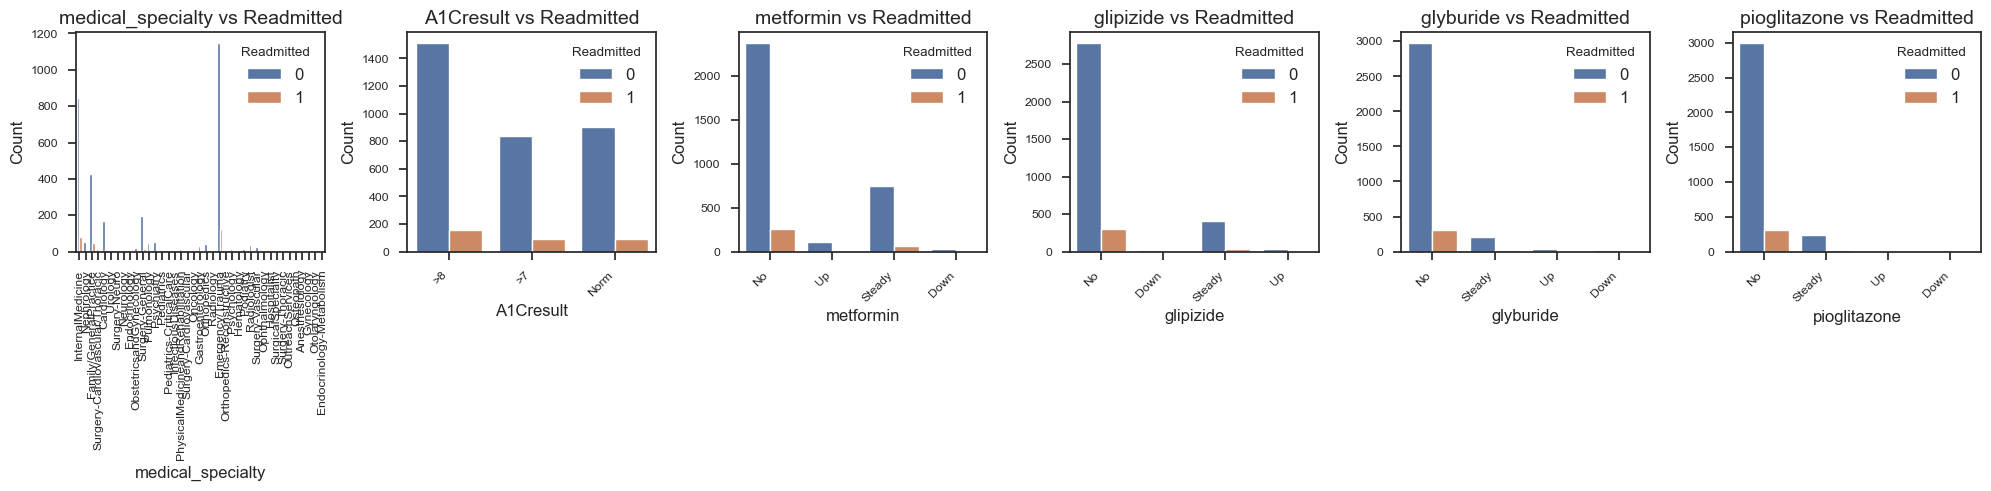

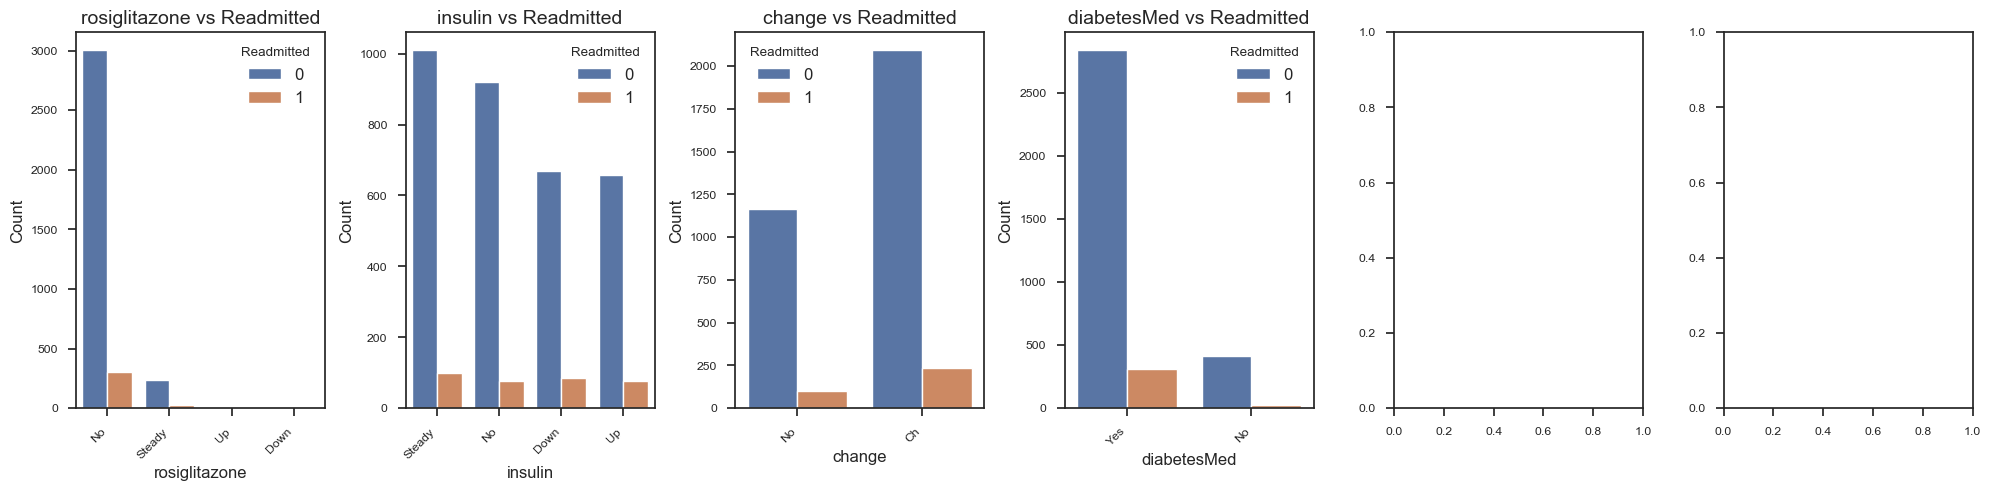

In [645]:
diabetes_countplot = diabetes_curated.copy()
specialties = {spec: i+1 for i, spec in enumerate(diabetes_countplot['medical_specialty'].unique())}
diabetes_countplot['medical_specialty'] = diabetes_countplot['medical_specialty'].map(specialties)

cols2 = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
         'payer_code', 'medical_specialty', 'A1Cresult',
         'metformin', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'change', 'diabetesMed']

nrows, ncols = 3, 6
figsize = (20, 5)

for i in range(0, len(cols2), ncols):
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for j, col in enumerate(cols2[i:i+ncols]):
        ax = axes[j]
        sns.countplot(x=col, hue="readmitted", data=diabetes_countplot, ax=ax)
        ax.set_title(f'{col} vs Readmitted', fontsize=14)
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        ax.legend(title="Readmitted", fontsize=12)

        if col == 'medical_specialty':
            labels = [spec for spec, _ in sorted(specialties.items(), key=lambda x: x[1])]
            ax.set_xticks(range(len(labels)))
            ax.set_xticklabels(labels, rotation=90)
        else:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# 3. Initial Predictive Modeling and Evaluation

## *Functions to use throughout the code for model evaluation*

In [704]:
# This function plots horizontal bar charts for model performance metrics across training, validation, and test datasets.
def plot_performance_metrics(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred):
    # Calculate performance metrics for training, validation, and test sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    train_roc_auc = roc_auc_score(y_train, y_train_pred)

    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    val_roc_auc = roc_auc_score(y_val, y_val_pred)

    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_roc_auc = roc_auc_score(y_test, y_test_pred)

    # Create a DataFrame for the performance metrics
    metrics_df = pd.DataFrame({
        'Metric': ['ROC AUC', 'F1 Score', 'Recall', 'Precision', 'Accuracy'],
        'Test Set': [test_roc_auc, test_f1, test_recall, test_precision, test_accuracy],
        'Validation Set': [val_roc_auc, val_f1, val_recall, val_precision, val_accuracy],
        'Training Set': [train_roc_auc, train_f1, train_recall, train_precision, train_accuracy]
    })

    # Plot the performance metrics as a horizontal bar graph
    ax = metrics_df.plot(kind='barh', x='Metric', figsize=(10, 6))
    plt.title('Model Performance Metrics')
    plt.ylabel('Metric')
    plt.xlabel('Score')
    plt.legend(title='Dataset')

    # Remove the top and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Label the bars with their respective values horizontally
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', label_type='edge', padding=5)

    plt.tight_layout()
    plt.show()

# Plots a confusion matrix using Seaborn's heatmap function with fixed class names, figure size, and color map. Returns: A matplotlib figure displaying the confusion matrix with annotations
def plot_confusion_matrix(y_true, y_pred):
    # Fixed class names
    class_names = ["0", "1"]

    # Calculate confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Create an array with the names, counts, and percentages
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f"{name}\n{count}\n{percentage}" for name, count, percentage in zip(group_names, group_counts, group_percentages)]

    # Reshape the labels array to match the confusion matrix shape
    labels = np.asarray(labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

    # Set the seaborn heatmap
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    # Configure the plot with titles and labels
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


def plot_learning_curve(X_train, y_train, X_val, y_val, X_test, y_test, title):
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, cv_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5),
        scoring='accuracy'
    )

    val_scores = []
    for train_size in train_sizes:
        model.fit(X_train[:int(train_size * len(X_train))], y_train[:int(train_size * len(X_train))])
        val_score = model.score(X_val, y_val)
        val_scores.append(val_score)

    test_scores = []
    for train_size in train_sizes:
        model.fit(X_train[:int(train_size * len(X_train))], y_train[:int(train_size * len(X_train))])
        test_score = model.score(X_test, y_test)
        test_scores.append(test_score)

    train_scores_mean = np.mean(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    val_scores_mean = np.mean(val_scores)
    test_scores_mean = np.mean(test_scores)

    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, cv_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.plot(train_sizes, [val_scores_mean] * len(train_sizes), 'o-', color="c", label="Validation score")
    plt.plot(train_sizes, [test_scores_mean] * len(train_sizes), 'o-', color="b", label="Test score")

    plt.legend(loc="best")
    plt.show()


## Building the logistic regression model

### Selecting the predictors

In [647]:
predictors = ['time_in_hospital', 'num_lab_procedures', 'num_medications', 'number_diagnoses', 'age',
              'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'num_procedures', 'number_inpatient'] # selected based on the correlation matrix

### Splitting the data into features (X) and target (y)

In [648]:
X = diabetes_normalised[predictors]
y = diabetes_normalised['readmitted']

# Converting categorical variables to numerical using one-hot encoding
X = pd.get_dummies(X)

### Splitting the data into train and test sets

In [649]:
### Splitting the data into train, validation, and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Training the logistic regression model

In [650]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [708]:
# Training and predecting the model
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)
y_test_inital = y_test

## Evaluating the model using different performance metrics

### Performance metrics

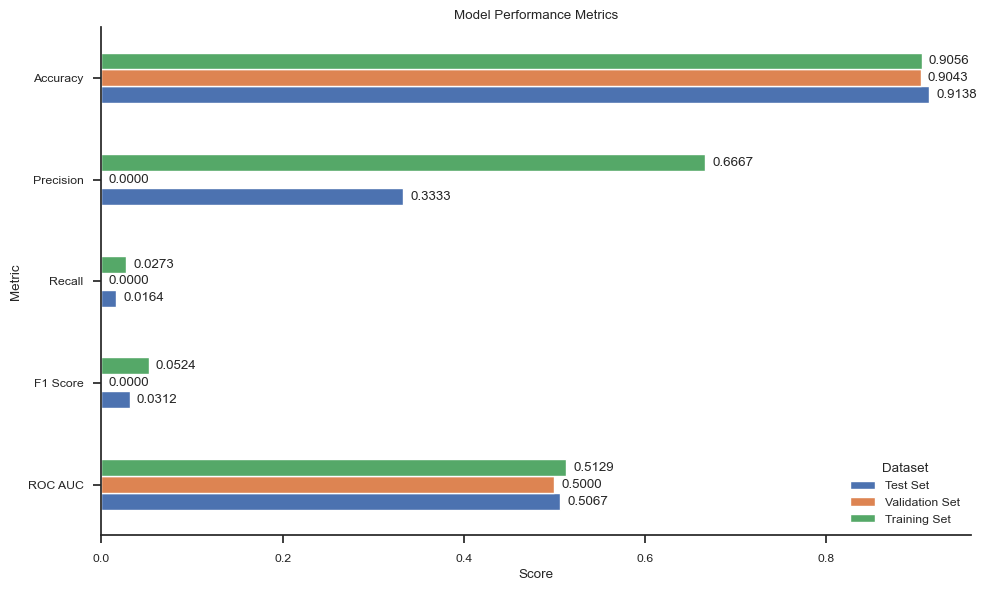

In [652]:
# Plot the performance metrics
plot_performance_metrics(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred)

### Cross-validation scores

In [653]:
# Perform cross-validation on the initial model
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.90652174 0.9        0.90869565 0.90434783 0.90631808]
Mean cross-validation score: 0.9051766600359951


### Confusion matrix

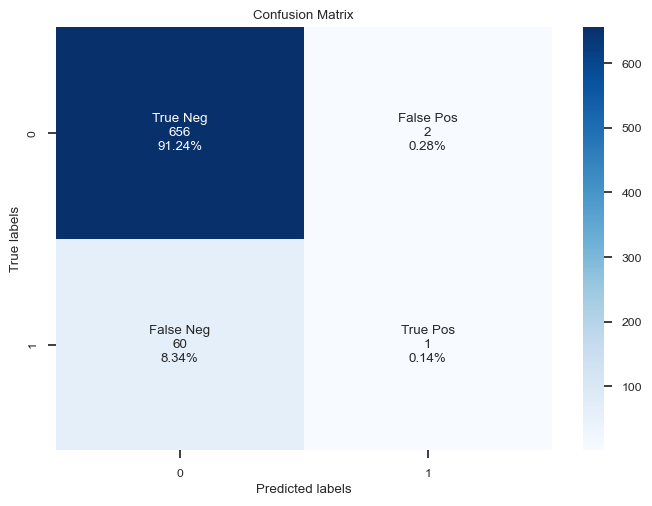

array([[656,   2],
       [ 60,   1]])

In [654]:
# confusion matrix
plot_confusion_matrix(y_test, y_test_pred)

confusion_matrix(y_test, y_test_pred)

⚠️ **Note on Confusion Matrix from sklearn's confusion_matrix function:** ⚠️
The output of confusion_matrix is in the format:
[[True Negative (TN), False Positive (FP)],
[False Negative (FN), True Positive (TP)]]
This arrangement may differ from some presentations or expectations where TP and TN might be more prominently positioned or discussed. It's crucial to carefully interpret these outputs, especially when communicating the performance of a model.

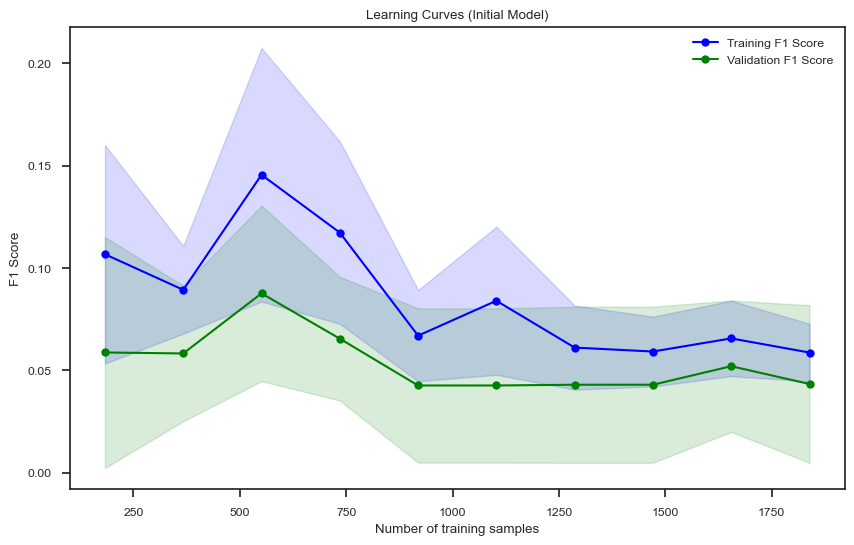

In [656]:
# Plotting learning curves for the initial model (F1 score)
train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', label='Training F1 Score')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, val_mean, color='green', marker='o', label='Validation F1 Score')
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')
plt.xlabel('Number of training samples')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Learning Curves (Initial Model)')
plt.show()

## Balancing the data and retraining the model

In [657]:
# Applying SMOTE to balance the data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Training the logistic regression model on the balanced data
model_balanced = LogisticRegression(random_state=42)
model_balanced.fit(X_resampled, y_resampled)

LogisticRegression(random_state=42)

In [658]:
# Predict on the train, validation, and test sets using the balanced model
y_train_pred_balanced = model_balanced.predict(X_resampled)
y_val_pred_balanced = model_balanced.predict(X_val)
y_test_pred_balanced = model_balanced.predict(X_test)

### Evaluating the balanced model

### Performance metrics

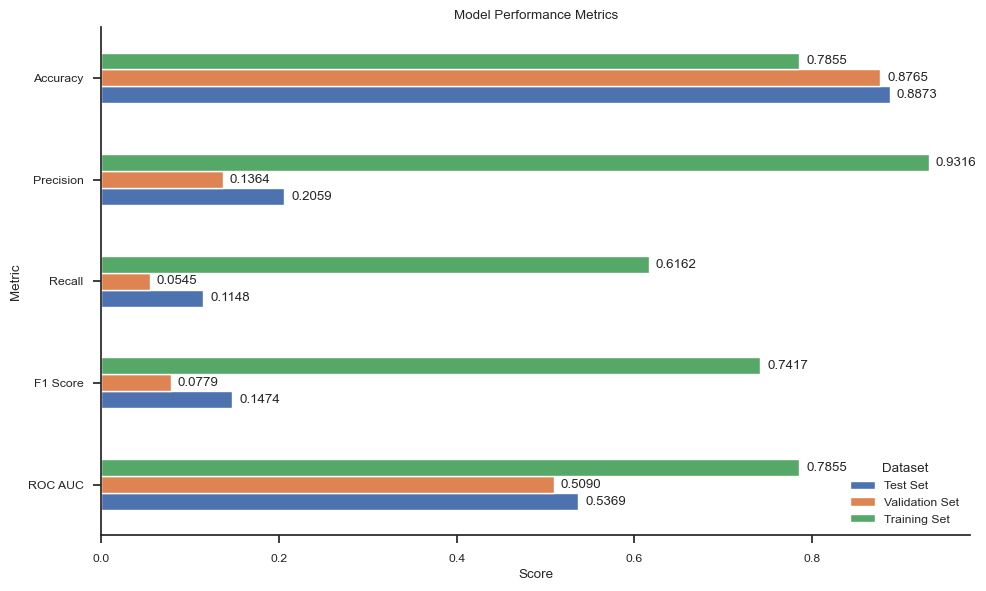

In [659]:
# Plot the performance metrics for the balanced model
plot_performance_metrics(y_resampled, y_train_pred_balanced, y_val, y_val_pred_balanced, y_test, y_test_pred_balanced)

The balanced model shows some improvement in recall and F1-score, indicating better performance on the minority class. However, the overall performance is still relatively low, suggesting that further improvements or alternative modeling approaches is needed.

### Cross-validation scores

In [660]:
# Perform cross-validation on the balanced model
cv_scores_balanced = cross_val_score(model_balanced, X_resampled, y_resampled, cv=5, scoring='accuracy')
print("Cross-validation scores for the balanced model:", cv_scores_balanced)
print("Mean cross-validation score for the balanced model:", cv_scores_balanced.mean())

Cross-validation scores for the balanced model: [0.66947115 0.80288462 0.80889423 0.81949458 0.81949458]
Mean cross-validation score for the balanced model: 0.7840478339350181


### Confusion matrix

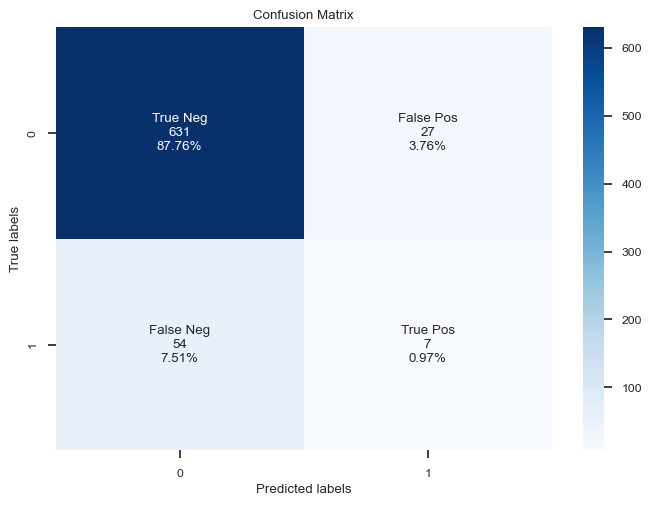

array([[631,  27],
       [ 54,   7]])

In [661]:
# Plot the confusion matrix for the balanced model
plot_confusion_matrix(y_test, y_test_pred_balanced)

confusion_matrix(y_test, y_test_pred_balanced)

⚠️ **Note on Confusion Matrix from sklearn's confusion_matrix function:** ⚠️
The output of confusion_matrix is in the format:
[[True Negative (TN), False Positive (FP)],
[False Negative (FN), True Positive (TP)]]
This arrangement may differ from some presentations or expectations where TP and TN might be more prominently positioned or discussed. It's crucial to carefully interpret these outputs, especially when communicating the performance of a model.


## ROC curves before and after balancing and re-training

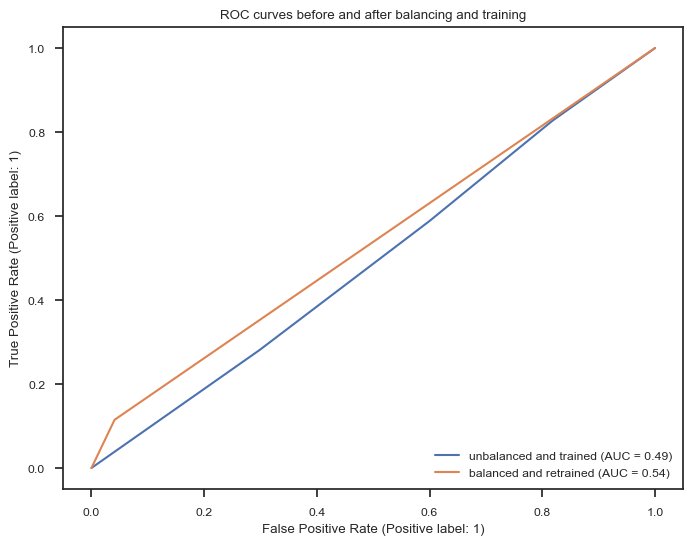

In [711]:
fig, ax = plt.subplots(figsize=(8,6))
RocCurveDisplay.from_predictions(y_test_inital, y_test_pred, name='unbalanced and trained', ax=ax)
RocCurveDisplay.from_predictions(y_test, y_test_pred_balanced, name='balanced and retrained', ax=ax)
ax.set_title('ROC curves before and after balancing and training')
plt.show()

# 4. Improved Modeling

## Data Cleansing and Processing

### Importing the data and showing the shape of the data

In [663]:
enhanced_model = diabetes_df.copy()
enhanced_model.shape

(101766, 50)

### Removing the 'encounter_id' and 'patient_nbr' columns from the dataframe

In [664]:
enhanced_model.drop(columns=['encounter_id'], inplace=True)
enhanced_model.drop(columns=['patient_nbr'], inplace=True)

### Replacing ? with NaN

In [665]:
enhanced_model.replace('?', np.nan, inplace = True)

### Deleting columns with high percentage of missing values

In [666]:
missing_percentages = enhanced_model.isna().mean() * 100
enhanced_model = enhanced_model.loc[:, missing_percentages < 95]

### Identifying zero variance columns

In [667]:
# Columns where the most frequent value accounts for 99% which are rounded zero variance columns
threshold = 0.99
zero_var_columns = enhanced_model.columns[enhanced_model.apply(lambda x: x.value_counts(normalize=True).iloc[0] >= threshold)]

# Deleting the identified near-zero variance columns from the DataFrame
enhanced_model.drop(columns=zero_var_columns, inplace=True)

print("zero variance columns deleted:", zero_var_columns.tolist())

zero variance columns deleted: ['nateglinide', 'chlorpropamide', 'acetohexamide', 'tolbutamide', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']


In [668]:
enhanced_model.shape

(101766, 32)

### Changing the 'age' from ranges to numbers

In [669]:
replaceDict = {'[0-10)' : 5,
'[10-20)' : 15,
'[20-30)' : 25,
'[30-40)' : 35,
'[40-50)' : 45,
'[50-60)' : 55,
'[60-70)' : 65,
'[70-80)' : 75,
'[80-90)' : 85,
'[90-100)' : 95}

enhanced_model['age'] = enhanced_model['age'].apply(lambda x : replaceDict[x])
print(enhanced_model['age'].head())

0     5
1    15
2    25
3    35
4    45
Name: age, dtype: int64


### Checking the different categories for 'gender'

In [670]:
### there were only 3 instances for 'unknown/invalid' so we decided to just remove them (to simplfy the model to pprevent overfitting)
print("there are", enhanced_model['gender'].nunique(), "unique classes for gender")
print("the number of patients with unknown/invalid gender is: ", len(enhanced_model[enhanced_model['gender']=='Unknown/Invalid']))
print("the number of patients with female gender is: ", len(enhanced_model[enhanced_model['gender']=='Female']))
print("the number of patients with male gender is: ", len(enhanced_model[enhanced_model['gender']=='Male']))

there are 3 unique classes for gender
the number of patients with unknown/invalid gender is:  3
the number of patients with female gender is:  54708
the number of patients with male gender is:  47055


due to the low frequency of 'unknown/invalid' gender we decided to remove them

In [671]:
# Filter out rows where gender is 'Unknown/Invalid'
enhanced_model = enhanced_model[enhanced_model['gender'] != 'Unknown/Invalid']

### creating binary variables (so the model learns better)

In [672]:
enhanced_model['readmitted'].replace({'<30': 1, '>30': 0, 'NO': 0}, inplace = True)

### Imputation on categorical and numerical features

In [673]:
# Imputation on categorical and numerical features
categorical_cols = enhanced_model.select_dtypes(include=['object']).columns
impute_cat = SimpleImputer(strategy='most_frequent')
enhanced_model[categorical_cols] = impute_cat.fit_transform(enhanced_model[categorical_cols])

In [674]:
# Imputation on numerical features
numerical_cols = enhanced_model.select_dtypes(include=['float64', 'int']).columns
imputer_num = SimpleImputer(strategy='mean')
enhanced_model[numerical_cols] = imputer_num.fit_transform(enhanced_model[numerical_cols])

In [675]:
enhanced_model.shape

(101763, 32)

### Plot the distribution of Readmitted and not readmitted

Text(0, 0.5, 'Number of Patients')

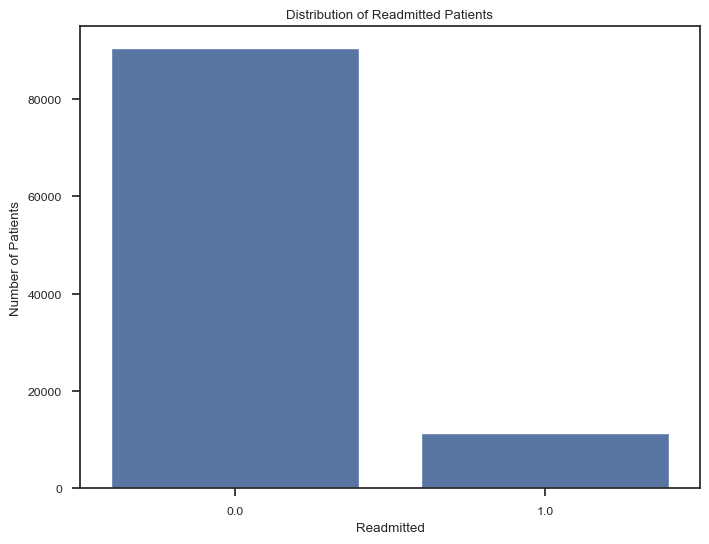

In [676]:
plt.figure(figsize=(8, 6))
sns.countplot(x='readmitted', data=enhanced_model)
plt.title('Distribution of Readmitted Patients')
plt.xlabel('Readmitted')
plt.ylabel('Number of Patients')

### Applying robust scaler normalisation

In [677]:
enhanced_model_normalised = enhanced_model.copy()

In [678]:
scaler = RobustScaler()
scaler.fit(enhanced_model_normalised[numerical_cols])
enhanced_model_normalised[numerical_cols] = scaler.transform(enhanced_model_normalised[numerical_cols])

In [679]:
df_encoded = enhanced_model_normalised.copy()
label_encoder = LabelEncoder()
for column in  enhanced_model_normalised.select_dtypes(include=['object']).columns:
    df_encoded[column] = label_encoder.fit_transform( enhanced_model_normalised[column])

In [680]:
df_encoded.shape

(101763, 32)

In [681]:
df_encoded.head()

race  gender  age  admission_type_id  discharge_disposition_id  \
0     2       0 -3.0                2.5                       8.0   
1     2       0 -2.5                0.0                       0.0   
2     0       0 -2.0                0.0                       0.0   
3     2       1 -1.5                0.0                       0.0   
4     2       1 -1.0                0.0                       0.0   

   admission_source_id  time_in_hospital  payer_code  medical_specialty  \
0                 -1.0             -0.75           7                 37   
1                  0.0             -0.25           7                 18   
2                  0.0             -0.50           7                 18   
3                  0.0             -0.50           7                 18   
4                  0.0             -0.75           7                 18   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0           -0.115385            -0.5             -1.4                0.0   
1            0.576923            -0.5              0.3                0.0   
2           -1.269231             2.0             -0.2                2.0   
3            0.000000             0.0              0.1                0.0   
4            0.269231            -0.5             -0.7                0.0   

   number_emergency  number_inpatient  diag_1  diag_2  diag_3  \
0               0.0               0.0     124     133      86   
1               0.0               0.0     143      79     121   
2               0.0               1.0     454      78     766   
3               0.0               0.0     554      97     248   
4               0.0               0.0      54      24      86   

   number_diagnoses  max_glu_serum  A1Cresult  metformin  repaglinide  \
0         -2.333333              2          1          1            1   
1          0.333333              2          1          1            1   
2         -0.666667              2          1          1            1   
3         -0.333333              2          1          1            1   
4         -1.000000              2          1          1            1   

   glimepiride  glipizide  glyburide  pioglitazone  rosiglitazone  insulin  \
0            1          1          1             1              1        1   
1            1          1          1             1              1        3   
2            1          2          1             1              1        1   
3            1          1          1             1              1        3   
4            1          2          1             1              1        2   

   change  diabetesMed  readmitted  
0       1            0         0.0  
1       0            1         0.0  
2       1            1         0.0  
3       0            1         0.0  
4       0            1         0.0

### Checking Value of 1 as graph is skewed towards one value

In [682]:
readmitted_count_0 = df_encoded['readmitted'].value_counts()[0]
readmitted_count_1 = df_encoded['readmitted'].value_counts()[1]
print("Number of Not Readmiited and Readmitted in cleaned dataframe is: ", readmitted_count_0, "and", readmitted_count_1)
df_encoded.describe()

Number of Not Readmiited and Readmitted in cleaned dataframe is:  90406 and 11357


race         gender            age  admission_type_id  \
count  101763.000000  101763.000000  101763.000000      101763.000000   
mean        1.665753       0.462398       0.048343           0.512008   
std         0.853725       0.498587       0.797051           0.722707   
min         0.000000       0.000000      -3.000000           0.000000   
25%         2.000000       0.000000      -0.500000           0.000000   
50%         2.000000       0.000000       0.000000           0.000000   
75%         2.000000       1.000000       0.500000           1.000000   
max         4.000000       1.000000       1.500000           3.500000   

       discharge_disposition_id  admission_source_id  time_in_hospital  \
count             101763.000000        101763.000000     101763.000000   
mean                   0.905172            -0.207590          0.099005   
std                    1.759973             0.677352          0.746273   
min                    0.000000            -1.000000         -0.750000   
25%                    0.000000            -1.000000         -0.500000   
50%                    0.000000             0.000000          0.000000   
75%                    1.000000             0.000000          0.500000   
max                    9.000000             3.000000          2.500000   

          payer_code  medical_specialty  num_lab_procedures  num_procedures  \
count  101763.000000      101763.000000       101763.000000   101763.000000   
mean        7.050254          20.034698           -0.034773        0.169846   
std         2.764352          13.354225            0.756701        0.852896   
min         0.000000           0.000000           -1.653846       -0.500000   
25%         7.000000          18.000000           -0.500000       -0.500000   
50%         7.000000          18.000000            0.000000        0.000000   
75%         7.000000          18.000000            0.500000        0.500000   
max        16.000000          71.000000            3.384615        2.500000   

       num_medications  number_outpatient  number_emergency  number_inpatient  \
count    101763.000000      101763.000000     101763.000000     101763.000000   
mean          0.102184           0.369368          0.197842          0.635585   
std           0.812759           1.267282          0.930485          1.262877   
min          -1.400000           0.000000          0.000000          0.000000   
25%          -0.500000           0.000000          0.000000          0.000000   
50%           0.000000           0.000000          0.000000          0.000000   
75%           0.500000           0.000000          0.000000          1.000000   
max           6.600000          42.000000         76.000000         21.000000   

              diag_1         diag_2         diag_3  number_diagnoses  \
count  101763.000000  101763.000000  101763.000000     101763.000000   
mean      336.757260     275.950591     278.109637         -0.192450   
std       160.530236     152.866058     176.132141          0.644526   
min         0.000000       0.000000       0.000000         -2.333333   
25%       259.000000     142.000000     139.000000         -0.666667   
50%       298.000000     260.000000     255.000000          0.000000   
75%       435.000000     373.000000     358.500000          0.333333   
max       715.000000     747.000000     788.000000          2.666667   

       max_glu_serum      A1Cresult      metformin    repaglinide  \
count  101763.000000  101763.000000  101763.000000  101763.000000   
mean        1.958394       1.011576       1.195592       1.015320   
std         0.262796       0.293874       0.435441       0.134654   
min         0.000000       0.000000       0.000000       0.000000   
25%         2.000000       1.000000       1.000000       1.000000   
50%         2.000000       1.000000       1.000000       1.000000   
75%         2.000000       1.000000       1.000000       1.000000   
max         2.000000       2.000000       3.0000

### Correlation matrix for all columns

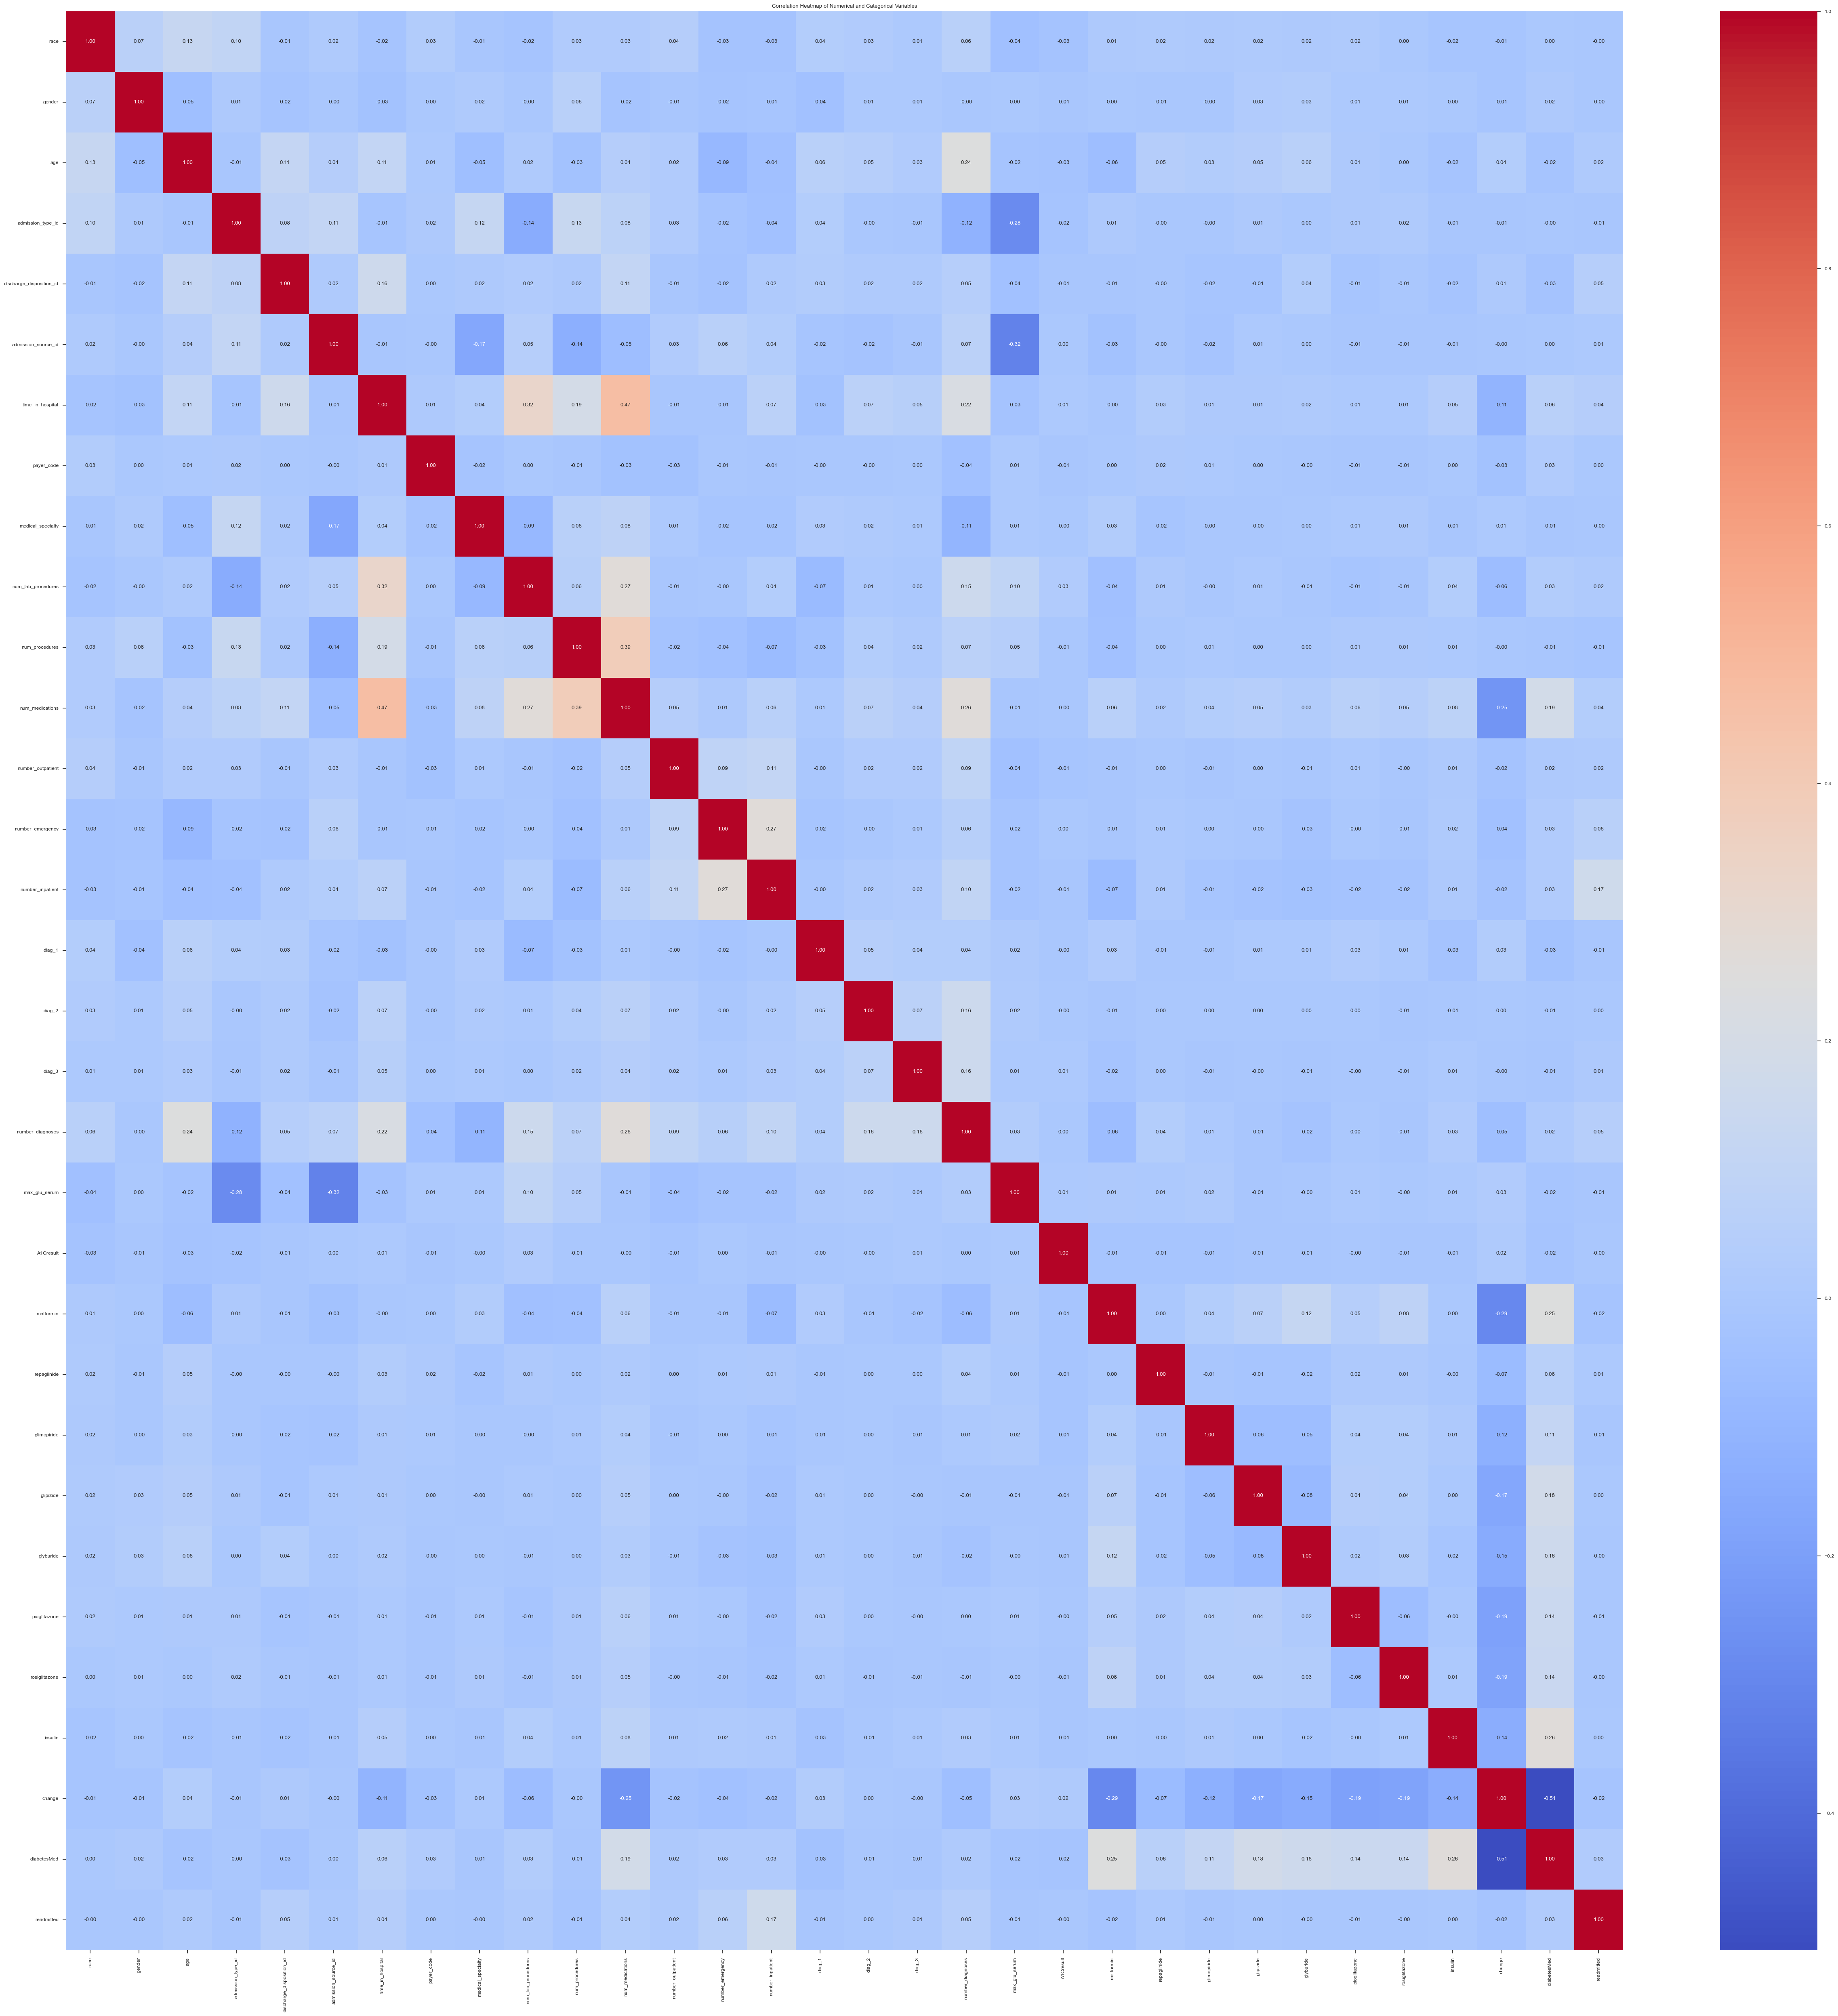

In [683]:
# Compute the correlation matrix for all columns
corr_matrix = df_encoded.corr()

# Create a heatmap
plt.figure(figsize=(50, 50))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical and Categorical Variables')
plt.tight_layout()
plt.show()

### Balancing Dataset Using Random Under-Sampling


In [684]:
# define X and y
X = df_encoded.drop('readmitted', axis=1) # X is all of the features from the data except the target variable
y = df_encoded['readmitted'] # y is the target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialise RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Perform undersampling on the training data
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [685]:
# Check the class distribution in the balanced data
print(f"Resampled dataset shape {y_resampled.shape}")
print(f"Class distribution: {pd.Series(y_resampled).value_counts()}")

Resampled dataset shape (18176,)
Class distribution: readmitted
0.0    9088
1.0    9088
Name: count, dtype: int64


The 'readmitted' has been successfully balances

## Model Building

### Selecting predictors

In [686]:
# Initialise the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_resampled, y_resampled)

# Get feature importances
importances = rf.feature_importances_

# Sort the feature importances in descending order
sorted_indices = importances.argsort()[::-1]

# Get the sum of the importances
total_importance = sum(importances)

# Convert the importances from decimals to percentages
importances_percentage = 100 * (importances / total_importance)

# Print the feature names along with their percentage importances
for idx in sorted_indices:
    print(f"{X_train.columns[idx]}: {importances_percentage[idx]:.2f}%")

num_lab_procedures: 8.88%
diag_1: 8.66%
diag_2: 8.39%
diag_3: 8.30%
num_medications: 7.63%
time_in_hospital: 5.39%
number_inpatient: 5.21%
age: 4.57%
discharge_disposition_id: 4.12%
medical_specialty: 3.72%
num_procedures: 3.72%
number_diagnoses: 3.63%
payer_code: 2.99%
insulin: 2.74%
admission_type_id: 2.74%
admission_source_id: 2.36%
race: 1.88%
number_outpatient: 1.88%
gender: 1.71%
number_emergency: 1.54%
metformin: 1.31%
change: 1.24%
glipizide: 1.23%
A1Cresult: 1.14%
glyburide: 1.12%
diabetesMed: 1.01%
pioglitazone: 0.82%
glimepiride: 0.70%
rosiglitazone: 0.69%
max_glu_serum: 0.39%
repaglinide: 0.27%


We decided to look at the importances as percentages as they were easier to interpret

#### RFECV for predictor selection

In [687]:
# Initialise a random forest classifier
estimator = RandomForestClassifier(n_estimators=100, random_state=42)

# Create the RFE object and compute a cross-validated score with F1 as the scoring metric
# StratifiedKFold is used to maintain the target distribution within each fold
cv_strategy = StratifiedKFold(n_splits=5)

# We are using accuracy score as the metric for scoring
scorer = make_scorer(accuracy_score)

# Initializs RFECV with the RandomForest estimator and accuracy scorer
rfecv = RFECV(estimator=estimator, step=1, cv=cv_strategy, scoring=scorer, verbose=1)

# Fit RFECV on the data
rfecv.fit(X, y)

# Print the optimal number of features
print(f"Optimal number of features: {rfecv.n_features_}")

# Retrieve the cross-validation scores
cv_scores = rfecv.cv_results_['mean_test_score']

# Transform the dataset to the optimal number of features
X_optimal_features = rfecv.transform(X)

Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features

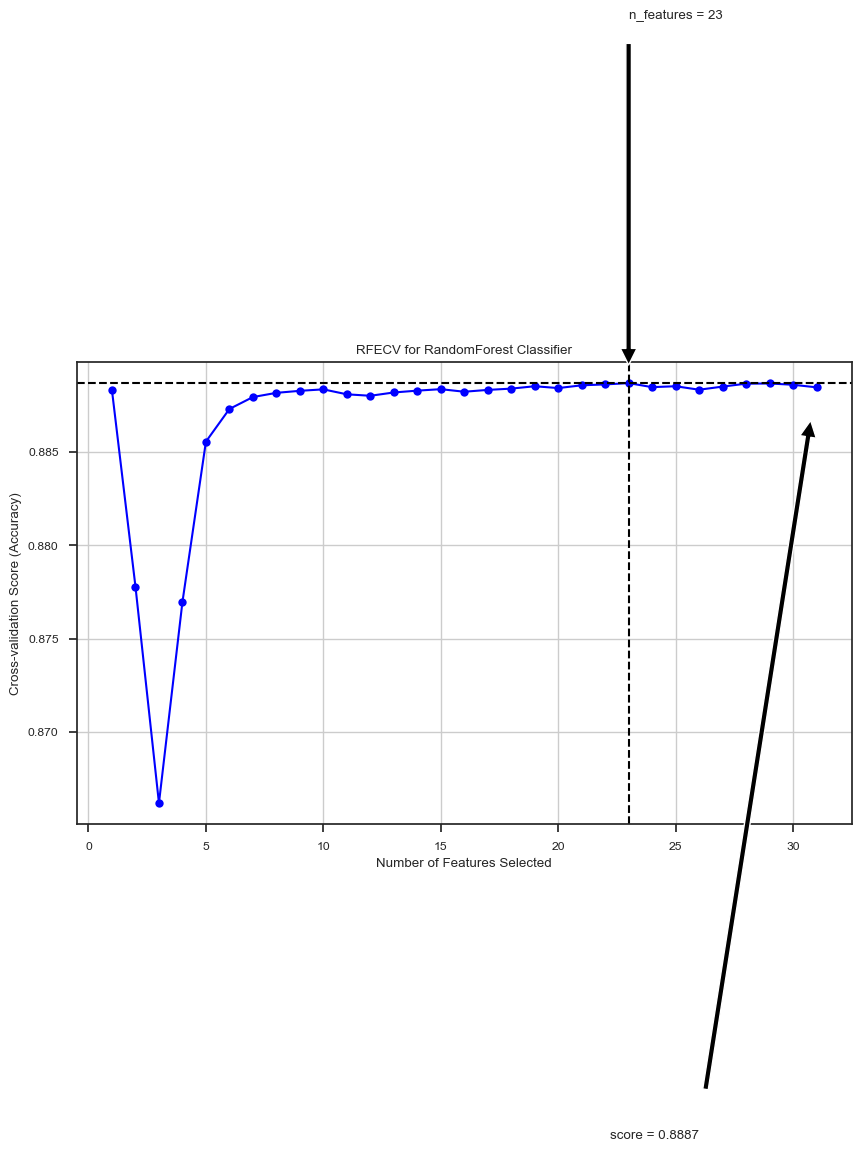

In [688]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-validation Score (Accuracy)")
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='-', color='blue')

# Highlight the point with the optimal number of features
optimal_num_features = rfecv.n_features_
optimal_score = max(cv_scores)

plt.axvline(x=optimal_num_features, linestyle='--', color='black')
plt.axhline(y=optimal_score, linestyle='--', color='black')

# Annotate the optimal number of features and score
plt.annotate(f'n_features = {optimal_num_features}',
             xy=(optimal_num_features, optimal_score),
             xytext=(optimal_num_features, optimal_score + 0.02),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='left', verticalalignment='top')

plt.annotate(f'score = {optimal_score:.4f}',
             xy=(len(cv_scores), optimal_score),
             xytext=(len(cv_scores) - 5, optimal_score - 0.04),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right', verticalalignment='top')

plt.title('RFECV for RandomForest Classifier')
plt.grid(True)
plt.show()

From the graph we understood that we need 23 features as predictors for our model to get the optimal cross validation score (for accuracy) of 0.8887.

In [689]:
# Print selected features
selected_features = [f for f, s in zip(X.columns, rfecv.support_) if s]
print(f"Selected features: {selected_features}")

Selected features: ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'metformin', 'glipizide', 'insulin', 'change']


This gave us the names of the features to use as predictors

In [690]:
# cluster_cols will contain the selected_features
cluster_cols = selected_features

# retreive the indicies for teh selected features
column_indices = [df_encoded.columns.get_loc(c) for c in cluster_cols if c in df_encoded.columns]

# print the indices
print(column_indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 24, 28, 29]


In [691]:
# filter the df_encoded for the columns with of the selected features
X = df_encoded.iloc[:, column_indices]
X.head()

race  gender  age  admission_type_id  discharge_disposition_id  \
0     2       0 -3.0                2.5                       8.0   
1     2       0 -2.5                0.0                       0.0   
2     0       0 -2.0                0.0                       0.0   
3     2       1 -1.5                0.0                       0.0   
4     2       1 -1.0                0.0                       0.0   

   admission_source_id  time_in_hospital  payer_code  medical_specialty  \
0                 -1.0             -0.75           7                 37   
1                  0.0             -0.25           7                 18   
2                  0.0             -0.50           7                 18   
3                  0.0             -0.50           7                 18   
4                  0.0             -0.75           7                 18   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0           -0.115385            -0.5             -1.4                0.0   
1            0.576923            -0.5              0.3                0.0   
2           -1.269231             2.0             -0.2                2.0   
3            0.000000             0.0              0.1                0.0   
4            0.269231            -0.5             -0.7                0.0   

   number_emergency  number_inpatient  diag_1  diag_2  diag_3  \
0               0.0               0.0     124     133      86   
1               0.0               0.0     143      79     121   
2               0.0               1.0     454      78     766   
3               0.0               0.0     554      97     248   
4               0.0               0.0      54      24      86   

   number_diagnoses  metformin  glipizide  insulin  change  
0         -2.333333          1          1        1       1  
1          0.333333          1          1        3       0  
2         -0.666667          1          2        1       1  
3         -0.333333          1          1        3       0  
4         -1.000000          1          2        2       0

we successfullly created a dataframe contaiing only the features we want to use as predictors

## K-Means clustering

### Determining K

### Running the elbow method to determine K

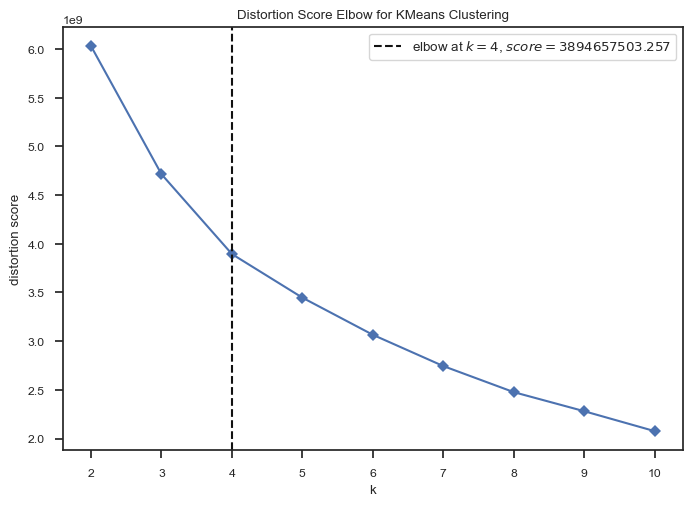

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [692]:
# Do the clustering and visualise the results
model = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 300, random_state = 42)
visualizer = KElbowVisualizer(
    model, k=(2,11), timings=False
)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

### visualising the distances between the clusters

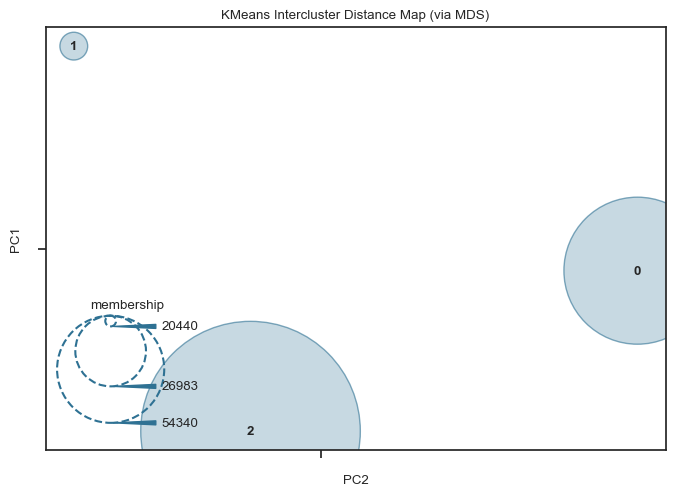

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [693]:
# Start the clustering and visualise
model = KMeans(n_clusters = 3, init = 'k-means++', n_init = 10, max_iter = 300, random_state = 42)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

Clusters are highly inbalanced (for k = 3), they vary in size.

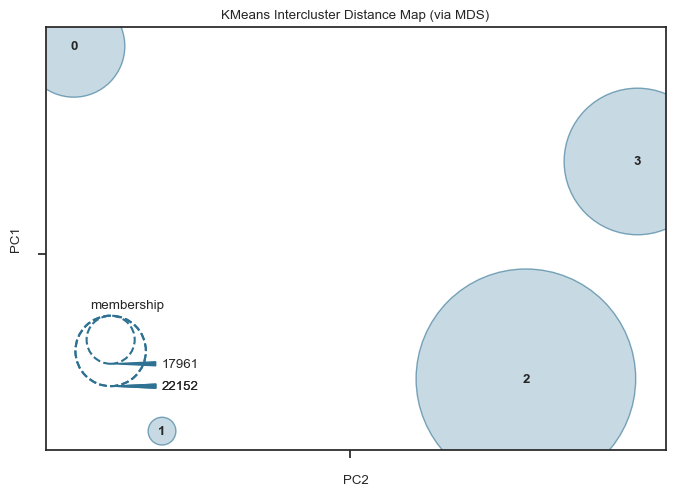

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [694]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import InterclusterDistance

# Start the clustering and visualise
model = KMeans(n_clusters = 4, init = 'k-means++', n_init = 10, max_iter = 300, random_state = 42)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

clusters are more balanced and distanced with k=4

### Visualising the cluster distributions to try to determine the value of k

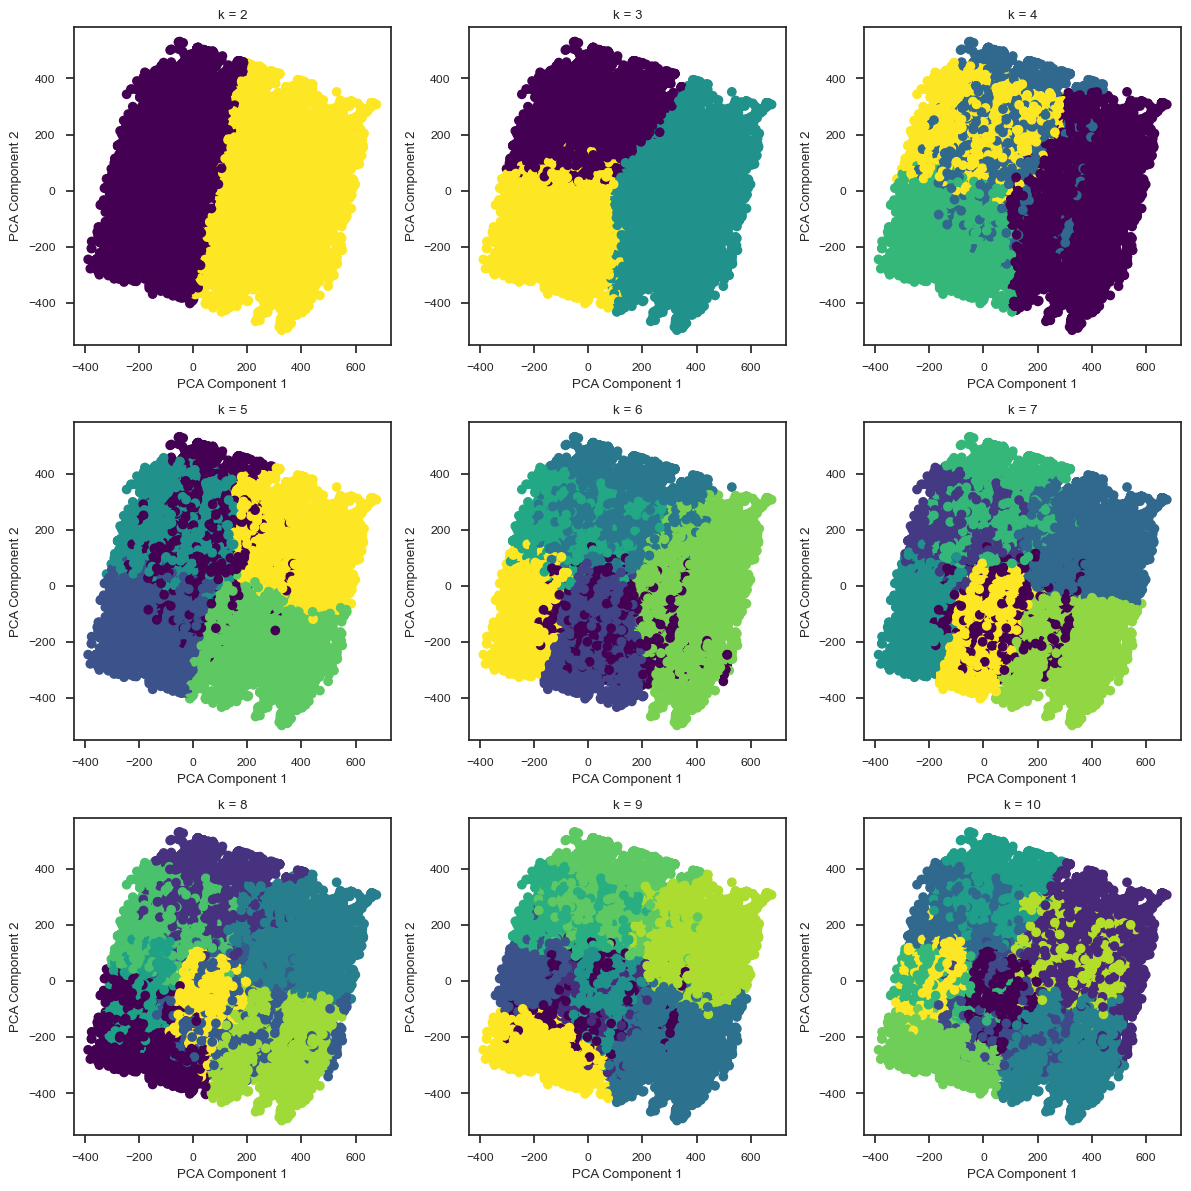

In [695]:
# Perform PCA for visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Range of k values to visualise is 2-10
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Create a figure and subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
axs = axs.flatten()

for i, k in enumerate(k_values):
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)

    # Plot the data points with cluster labels
    axs[i].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    axs[i].set_title(f'k = {k}')
    axs[i].set_xlabel('PCA Component 1')
    axs[i].set_ylabel('PCA Component 2')

# Remove the last subplot if k_values has less than 9 values
if len(k_values) < 9:
    fig.delaxes(axs[-1])

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

### Running the K-Means Clustering

In [696]:
# training the k-means on the dataset for a value of k
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans_clusters = kmeans.fit_predict(X)

we used k-means++ instead of the default value for this paramaeter. This is because k-means++ initiates the centroid of the cluster in a more 'intelligent' way than the random initilisation by k-means

In [697]:
# Add the cluster labels to the original dataframe
df_encoded['Cluster'] = kmeans_clusters
df_encoded.head()

race  gender  age  admission_type_id  discharge_disposition_id  \
0     2       0 -3.0                2.5                       8.0   
1     2       0 -2.5                0.0                       0.0   
2     0       0 -2.0                0.0                       0.0   
3     2       1 -1.5                0.0                       0.0   
4     2       1 -1.0                0.0                       0.0   

   admission_source_id  time_in_hospital  payer_code  medical_specialty  \
0                 -1.0             -0.75           7                 37   
1                  0.0             -0.25           7                 18   
2                  0.0             -0.50           7                 18   
3                  0.0             -0.50           7                 18   
4                  0.0             -0.75           7                 18   

   num_lab_procedures  num_procedures  num_medications  number_outpatient  \
0           -0.115385            -0.5             -1.4                0.0   
1            0.576923            -0.5              0.3                0.0   
2           -1.269231             2.0             -0.2                2.0   
3            0.000000             0.0              0.1                0.0   
4            0.269231            -0.5             -0.7                0.0   

   number_emergency  number_inpatient  diag_1  diag_2  diag_3  \
0               0.0               0.0     124     133      86   
1               0.0               0.0     143      79     121   
2               0.0               1.0     454      78     766   
3               0.0               0.0     554      97     248   
4               0.0               0.0      54      24      86   

   number_diagnoses  max_glu_serum  A1Cresult  metformin  repaglinide  \
0         -2.333333              2          1          1            1   
1          0.333333              2          1          1            1   
2         -0.666667              2          1          1            1   
3         -0.333333              2          1          1            1   
4         -1.000000              2          1          1            1   

   glimepiride  glipizide  glyburide  pioglitazone  rosiglitazone  insulin  \
0            1          1          1             1              1        1   
1            1          1          1             1              1        3   
2            1          2          1             1              1        1   
3            1          1          1             1              1        3   
4            1          2          1             1              1        2   

   change  diabetesMed  readmitted  Cluster  
0       1            0         0.0        2  
1       0            1         0.0        2  
2       1            1         0.0        0  
3       0            1         0.0        3  
4       0            1         0.0        2

## Random Forest Model Building

### Global predictive model

In [698]:
# Separating the features and target variable for the entire dataset
X = df_encoded.drop(['readmitted', 'Cluster'], axis=1)
y = df_encoded['readmitted']

# Splitting data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42) # train set is 60% of the data
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # test and validation set is 20% each of the data

# Balancing the training set using RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Training the RandomForest model
rf = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=10, max_features=23, min_samples_leaf=50) # these paremeter settings gave a non overfitting model
rf.fit(X_resampled, y_resampled)

# Evaluate using cross-validation
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Calculating cross-validated scores on the resampled training set
cv_score_train = cross_val_score(rf, X_resampled, y_resampled, cv=cv, scoring='accuracy').mean()
cv_score_val = cross_val_score(rf, X_val, y_val, cv=cv, scoring='accuracy').mean()
cv_score_test = cross_val_score(rf, X_test, y_test, cv=cv, scoring='accuracy').mean()

# Evaluating on the training set
y_train_pred = rf.predict(X_resampled)
print("Training Set Performance:")
print("Confusion Matrix:\n", confusion_matrix(y_resampled, y_train_pred))
print("Accuracy:", accuracy_score(y_resampled, y_train_pred))
print("Precision:", precision_score(y_resampled, y_train_pred, average='macro'))
print("Recall:", recall_score(y_resampled, y_train_pred, average='macro'))
print("F1 Score:", f1_score(y_resampled, y_train_pred, average='macro'))
print("ROC AUC:", roc_auc_score(y_resampled, y_train_pred, average='macro'))

# Evaluating on the validation set
y_val_pred = rf.predict(X_val)
print("Validation Set Performance:")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred, average='macro'))
print("Recall:", recall_score(y_val, y_val_pred, average='macro'))
print("F1 Score:", f1_score(y_val, y_val_pred, average='macro'))
print("ROC AUC:", roc_auc_score(y_val, y_val_pred, average='macro'))
print("Cross-val score:", cv_score_val)

# Evaluating on the test set
y_test_pred = rf.predict(X_test)
print("\nTest Set Performance:")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, average='macro'))
print("Recall:", recall_score(y_test, y_test_pred, average='macro'))
print("F1 Score:", f1_score(y_test, y_test_pred, average='macro'))
print("ROC AUC:", roc_auc_score(y_test, y_test_pred, average='macro'))
print("Cross-val score:", cv_score_test)

# Initialise the dictionary to store the model and its performance metrics
global_model_metrics = {}

# Storing test set performance
global_model_metrics['test_metrics'] = {
    'Confusion Matrix': confusion_matrix(y_test, y_test_pred),
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred, average='macro'),
    'Recall': recall_score(y_test, y_test_pred, average='macro'),
    'F1': f1_score(y_test, y_test_pred, average='macro'),
    'ROC AUC': roc_auc_score(y_test, y_test_pred, average='macro'),
    'Cross-val score': cv_score_test
}

# Storing the trained model
global_model_metrics['model'] = rf

Training Set Performance:
Confusion Matrix:
 [[4383 2380]
 [2220 4543]]
Accuracy: 0.6599142392429396
Precision: 0.6600037945799984
Recall: 0.6599142392429396
F1 Score: 0.6598666454385352
ROC AUC: 0.6599142392429395
Validation Set Performance:
Confusion Matrix:
 [[10944  7066]
 [  879  1464]]
Accuracy: 0.6096398565322065
Precision: 0.5486414651276315
Recall: 0.6162511792779797
F1 Score: 0.501487539658247
ROC AUC: 0.6162511792779797
Cross-val score: 0.8848818804516251

Test Set Performance:
Confusion Matrix:
 [[10872  7230]
 [  821  1430]]
Accuracy: 0.6044317790989043
Precision: 0.5474570364338309
Recall: 0.6179349155319618
F1 Score: 0.4959538362601167
ROC AUC: 0.6179349155319619
Cross-val score: 0.889402065040572


In [699]:
# Initialize a dictionary to store the models and their performance metrics
cluster_models = defaultdict(dict)

# for loop to build local classifiers for every cluster
for cluster in df_encoded['Cluster'].unique():
    print(f"\nTraining model for Cluster {cluster}")
    cluster_data = df_encoded[df_encoded['Cluster'] == cluster]

    # Separating the features and target variable
    X_filtered = cluster_data[selected_features]
    y = cluster_data['readmitted']

    # Splitting data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X_filtered, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Balancing the training set using RandomUnderSampler
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    # Training the RandomForest model
    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, max_features=23, min_samples_leaf=50)
    rf.fit(X_resampled, y_resampled)

    # Evaluate using cross-validation
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

    # Calculating cross-validated scores on the resampled training set
    cv_score_train = cross_val_score(rf, X_resampled, y_resampled, cv=cv, scoring='accuracy').mean()
    cv_score_val = cross_val_score(rf, X_val, y_val, cv=cv, scoring='accuracy').mean()
    cv_score_test = cross_val_score(rf, X_test, y_test, cv=cv, scoring='accuracy').mean()

    # Training set predictions
    y_train_pred = rf.predict(X_resampled)
    print("Training Set Performance for Cluster {}: ".format(cluster))
    print("Confusion Matrix:\n", confusion_matrix(y_resampled, y_train_pred))
    print("Accuracy:", accuracy_score(y_resampled, y_train_pred))
    print("Precision:", precision_score(y_resampled, y_train_pred, average='macro'))
    print("Recall:", recall_score(y_resampled, y_train_pred, average='macro'))
    print("F1 Score:", f1_score(y_resampled, y_train_pred, average='macro'))
    print("ROC AUC:", roc_auc_score(y_resampled, y_train_pred, average='macro'))


    # Evaluating on the validation set
    y_val_pred = rf.predict(X_val)
    print("Validation Set Performance:")
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("Precision:", precision_score(y_val, y_val_pred, average='macro'))
    print("Recall:", recall_score(y_val, y_val_pred, average='macro'))
    print("F1 Score:", f1_score(y_val, y_val_pred, average='macro'))
    print("ROC AUC:", roc_auc_score(y_val, y_val_pred))
    print("Cross-val score:", cv_score_val)

    # Storing validation set performance
    cluster_models[cluster]['validation_metrics'] = {
        'Confusion Matrix': confusion_matrix(y_val, y_val_pred),
        'Accuracy': accuracy_score(y_val, y_val_pred),
        'Precision': precision_score(y_val, y_val_pred, average='macro'),
        'Recall': recall_score(y_val, y_val_pred, average='macro'),
        'F1': f1_score(y_val, y_val_pred, average='macro'),
        'ROC AUC': roc_auc_score(y_val, y_val_pred),
        'Cross-val score': cv_score_val
    }

    # Evaluating on the test set
    y_test_pred = rf.predict(X_test)
    print("\nTest Set Performance:")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Precision:", precision_score(y_test, y_test_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_test_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_test_pred, average='macro'))
    print("ROC AUC:", roc_auc_score(y_test, y_test_pred))
    print("Cross-val score:", cv_score_test)

    # Storing test set performance
    cluster_models[cluster]['test_metrics'] = {
        'Confusion Matrix': confusion_matrix(y_test, y_test_pred),
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred, average='macro'),
        'Recall': recall_score(y_test, y_test_pred, average='macro'),
        'F1': f1_score(y_test, y_test_pred, average='macro'),
        'ROC AUC': roc_auc_score(y_test, y_test_pred),
        'Cross-val score': cv_score_test
    }

    # Storing the trained model
    cluster_models[cluster]['model'] = rf


Training model for Cluster 2
Training Set Performance for Cluster 2: 
Confusion Matrix:
 [[2138  847]
 [1119 1866]]
Accuracy: 0.6706867671691792
Precision: 0.6721158918141776
Recall: 0.6706867671691792
F1 Score: 0.6700017510655127
ROC AUC: 0.6706867671691793
Validation Set Performance:
Confusion Matrix:
 [[5233 2740]
 [ 462  535]]
Accuracy: 0.6430323299888517
Precision: 0.5411174929126259
Recall: 0.5964749887439819
F1 Score: 0.5080991687300446
ROC AUC: 0.5964749887439819
Cross-val score: 0.8888517279821627

Test Set Performance:
Confusion Matrix:
 [[5310 2631]
 [ 451  578]]
Accuracy: 0.6564102564102564
Precision: 0.5509166984952547
Recall: 0.6151959623506157
F1 Score: 0.5239197537773805
ROC AUC: 0.6151959623506156
Cross-val score: 0.8852842809364547

Training model for Cluster 0
Training Set Performance for Cluster 0: 
Confusion Matrix:
 [[814 399]
 [366 847]]
Accuracy: 0.6846661170651278
Precision: 0.6848028946867264
Recall: 0.6846661170651278
F1 Score: 0.6846077594828484
ROC AUC: 0.

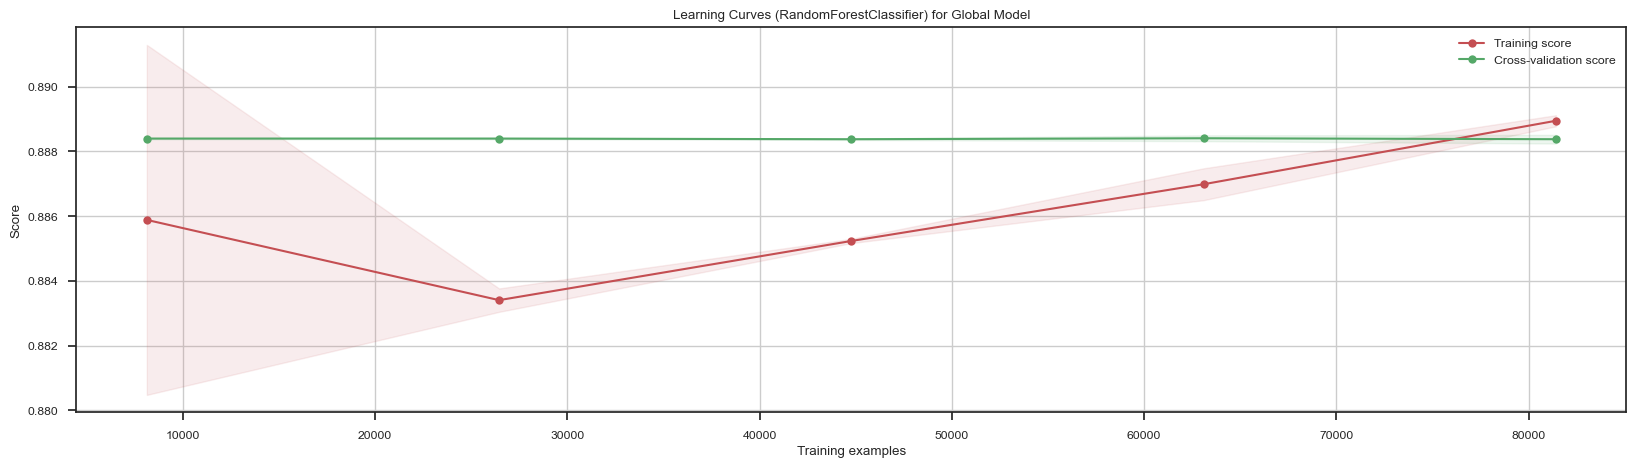

In [700]:
def plot_learning_curve2(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(20, 5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")

    return plt

# Assuming df_encoded is your dataframe and 'rf' is your RandomForestClassifier instance
X = df_encoded.drop(['readmitted'], axis=1)  # all features except the target variable
y = df_encoded['readmitted']                 # the target variable

# Use a 5-fold cross-validation
cv = 5
n_jobs = -1  # Use all available cores
title = "Learning Curves (RandomForestClassifier) for Global Model"

# Plot learning curve for the global model
plot_learning_curve2(rf, title, X, y, cv=cv, n_jobs=n_jobs)
plt.show()

## Cluster-based local classifier predictive model

In [701]:
# Initialize a dictionary to store the models and their performance metrics
cluster_models = defaultdict(dict)

# for loop to build local classifiers for every cluster
for cluster in df_encoded['Cluster'].unique():
    print(f"\nTraining model for Cluster {cluster}")
    cluster_data = df_encoded[df_encoded['Cluster'] == cluster]

    # Separating the features and target variable
    X_filtered = cluster_data[selected_features]
    y = cluster_data['readmitted']

    # Splitting data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X_filtered, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Balancing the training set using RandomUnderSampler
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

    # Training the RandomForest model
    rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, max_features=23, min_samples_leaf=50)
    rf.fit(X_resampled, y_resampled)

    # Evaluate using cross-validation
    cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

    # Calculating cross-validated scores on the resampled training set
    cv_score_train = cross_val_score(rf, X_resampled, y_resampled, cv=cv, scoring='accuracy').mean()
    cv_score_val = cross_val_score(rf, X_val, y_val, cv=cv, scoring='accuracy').mean()
    cv_score_test = cross_val_score(rf, X_test, y_test, cv=cv, scoring='accuracy').mean()

    # Training set predictions
    y_train_pred = rf.predict(X_resampled)
    print("Training Set Performance for Cluster {}: ".format(cluster))
    print("Confusion Matrix:\n", confusion_matrix(y_resampled, y_train_pred))
    print("Accuracy:", accuracy_score(y_resampled, y_train_pred))
    print("Precision:", precision_score(y_resampled, y_train_pred, average='macro'))
    print("Recall:", recall_score(y_resampled, y_train_pred, average='macro'))
    print("F1 Score:", f1_score(y_resampled, y_train_pred, average='macro'))
    print("ROC AUC:", roc_auc_score(y_resampled, y_train_pred, average='macro'))


    # Evaluating on the validation set
    y_val_pred = rf.predict(X_val)
    print("Validation Set Performance:")
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("Precision:", precision_score(y_val, y_val_pred, average='macro'))
    print("Recall:", recall_score(y_val, y_val_pred, average='macro'))
    print("F1 Score:", f1_score(y_val, y_val_pred, average='macro'))
    print("ROC AUC:", roc_auc_score(y_val, y_val_pred))
    print("Cross-val score:", cv_score_val)

    # Storing validation set performance
    cluster_models[cluster]['validation_metrics'] = {
        'Confusion Matrix': confusion_matrix(y_val, y_val_pred),
        'Accuracy': accuracy_score(y_val, y_val_pred),
        'Precision': precision_score(y_val, y_val_pred, average='macro'),
        'Recall': recall_score(y_val, y_val_pred, average='macro'),
        'F1': f1_score(y_val, y_val_pred, average='macro'),
        'ROC AUC': roc_auc_score(y_val, y_val_pred),
        'Cross-val score': cv_score_val
    }

    # Evaluating on the test set
    y_test_pred = rf.predict(X_test)
    print("\nTest Set Performance:")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Precision:", precision_score(y_test, y_test_pred, average='macro'))
    print("Recall:", recall_score(y_test, y_test_pred, average='macro'))
    print("F1 Score:", f1_score(y_test, y_test_pred, average='macro'))
    print("ROC AUC:", roc_auc_score(y_test, y_test_pred))
    print("Cross-val score:", cv_score_test)

    # Storing test set performance
    cluster_models[cluster]['test_metrics'] = {
        'Confusion Matrix': confusion_matrix(y_test, y_test_pred),
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred, average='macro'),
        'Recall': recall_score(y_test, y_test_pred, average='macro'),
        'F1': f1_score(y_test, y_test_pred, average='macro'),
        'ROC AUC': roc_auc_score(y_test, y_test_pred),
        'Cross-val score': cv_score_test
    }

    # Storing the trained model
    cluster_models[cluster]['model'] = rf


Training model for Cluster 2
Training Set Performance for Cluster 2: 
Confusion Matrix:
 [[2138  847]
 [1119 1866]]
Accuracy: 0.6706867671691792
Precision: 0.6721158918141776
Recall: 0.6706867671691792
F1 Score: 0.6700017510655127
ROC AUC: 0.6706867671691793
Validation Set Performance:
Confusion Matrix:
 [[5233 2740]
 [ 462  535]]
Accuracy: 0.6430323299888517
Precision: 0.5411174929126259
Recall: 0.5964749887439819
F1 Score: 0.5080991687300446
ROC AUC: 0.5964749887439819
Cross-val score: 0.8888517279821627

Test Set Performance:
Confusion Matrix:
 [[5310 2631]
 [ 451  578]]
Accuracy: 0.6564102564102564
Precision: 0.5509166984952547
Recall: 0.6151959623506157
F1 Score: 0.5239197537773805
ROC AUC: 0.6151959623506156
Cross-val score: 0.8852842809364547

Training model for Cluster 0
Training Set Performance for Cluster 0: 
Confusion Matrix:
 [[814 399]
 [366 847]]
Accuracy: 0.6846661170651278
Precision: 0.6848028946867264
Recall: 0.6846661170651278
F1 Score: 0.6846077594828484
ROC AUC: 0.

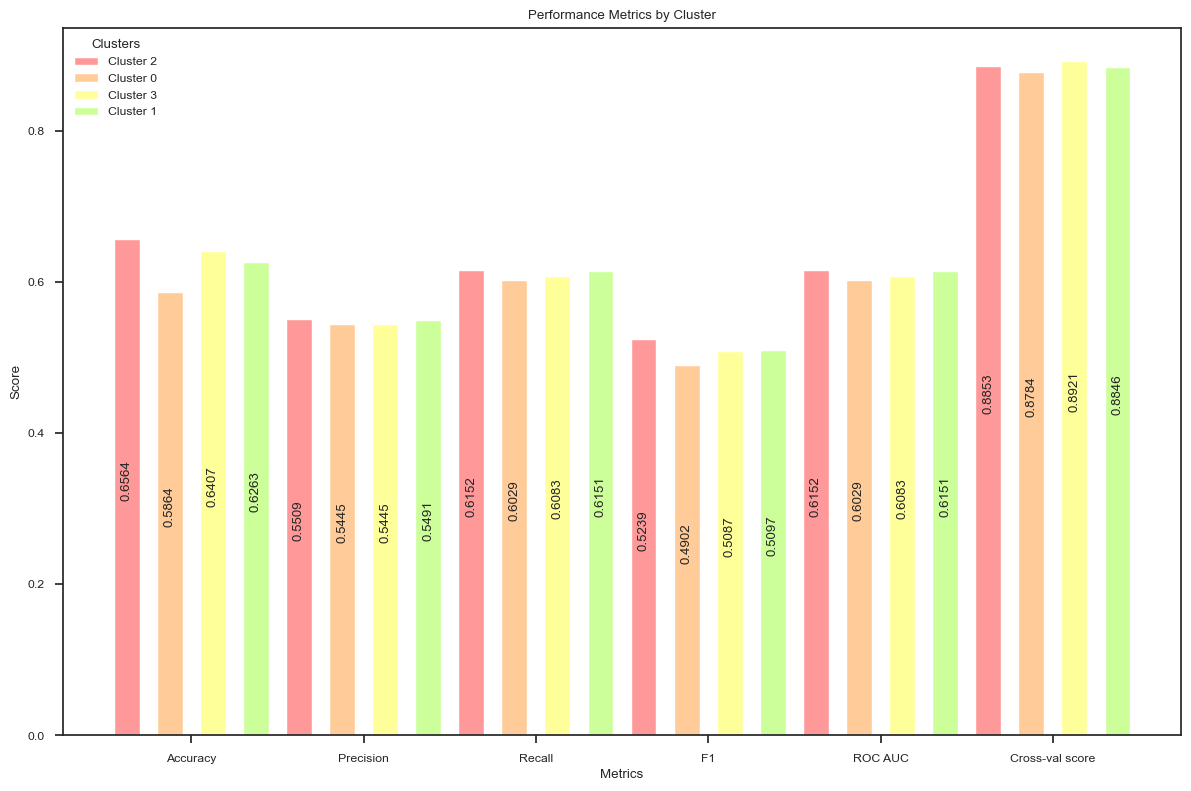

In [702]:
def plot_cluster_metrics(cluster_models):
    clusters = list(cluster_models.keys())
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'Cross-val score']

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set the width of each bar and the spacing between groups
    bar_width = 0.15
    group_spacing = 0.1

    # Define a custom list of colors
    colors = ['#FF9999', '#FFCC99', '#FFFF99', '#CCFF99', '#99FFCC', '#99FFFF', '#99CCFF', '#CC99FF']

    # Create a list to store the legend handles
    legend_handles = []

    # Iterate over each metric and plot the bars for each cluster
    for i, metric in enumerate(metrics):
        for j, cluster in enumerate(clusters):
            x = i + j * (bar_width + group_spacing)
            y = cluster_models[cluster].get('test_metrics', {}).get(metric, 0)  # Handle missing metrics
            bar = ax.bar(x, y, width=bar_width, color=colors[j % len(colors)])

            # Add the bar to the legend handles only for the first metric
            if i == 0:
                legend_handles.append(bar)

    # Set the x-tick positions and labels
    x_ticks = np.arange(len(metrics)) + (len(clusters) - 1) * (bar_width + group_spacing) / 2
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(metrics)

    # Add labels and title
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Score')
    ax.set_title('Performance Metrics by Cluster')

    # Label the bars with their respective values vertically
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', label_type='center', rotation=90, padding=5)

    # Add a legend on the top left of the graph
    ax.legend(legend_handles, [f'Cluster {cluster}' for cluster in clusters], loc='upper left', title='Clusters')

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot the cluster metrics
plot_cluster_metrics(cluster_models)

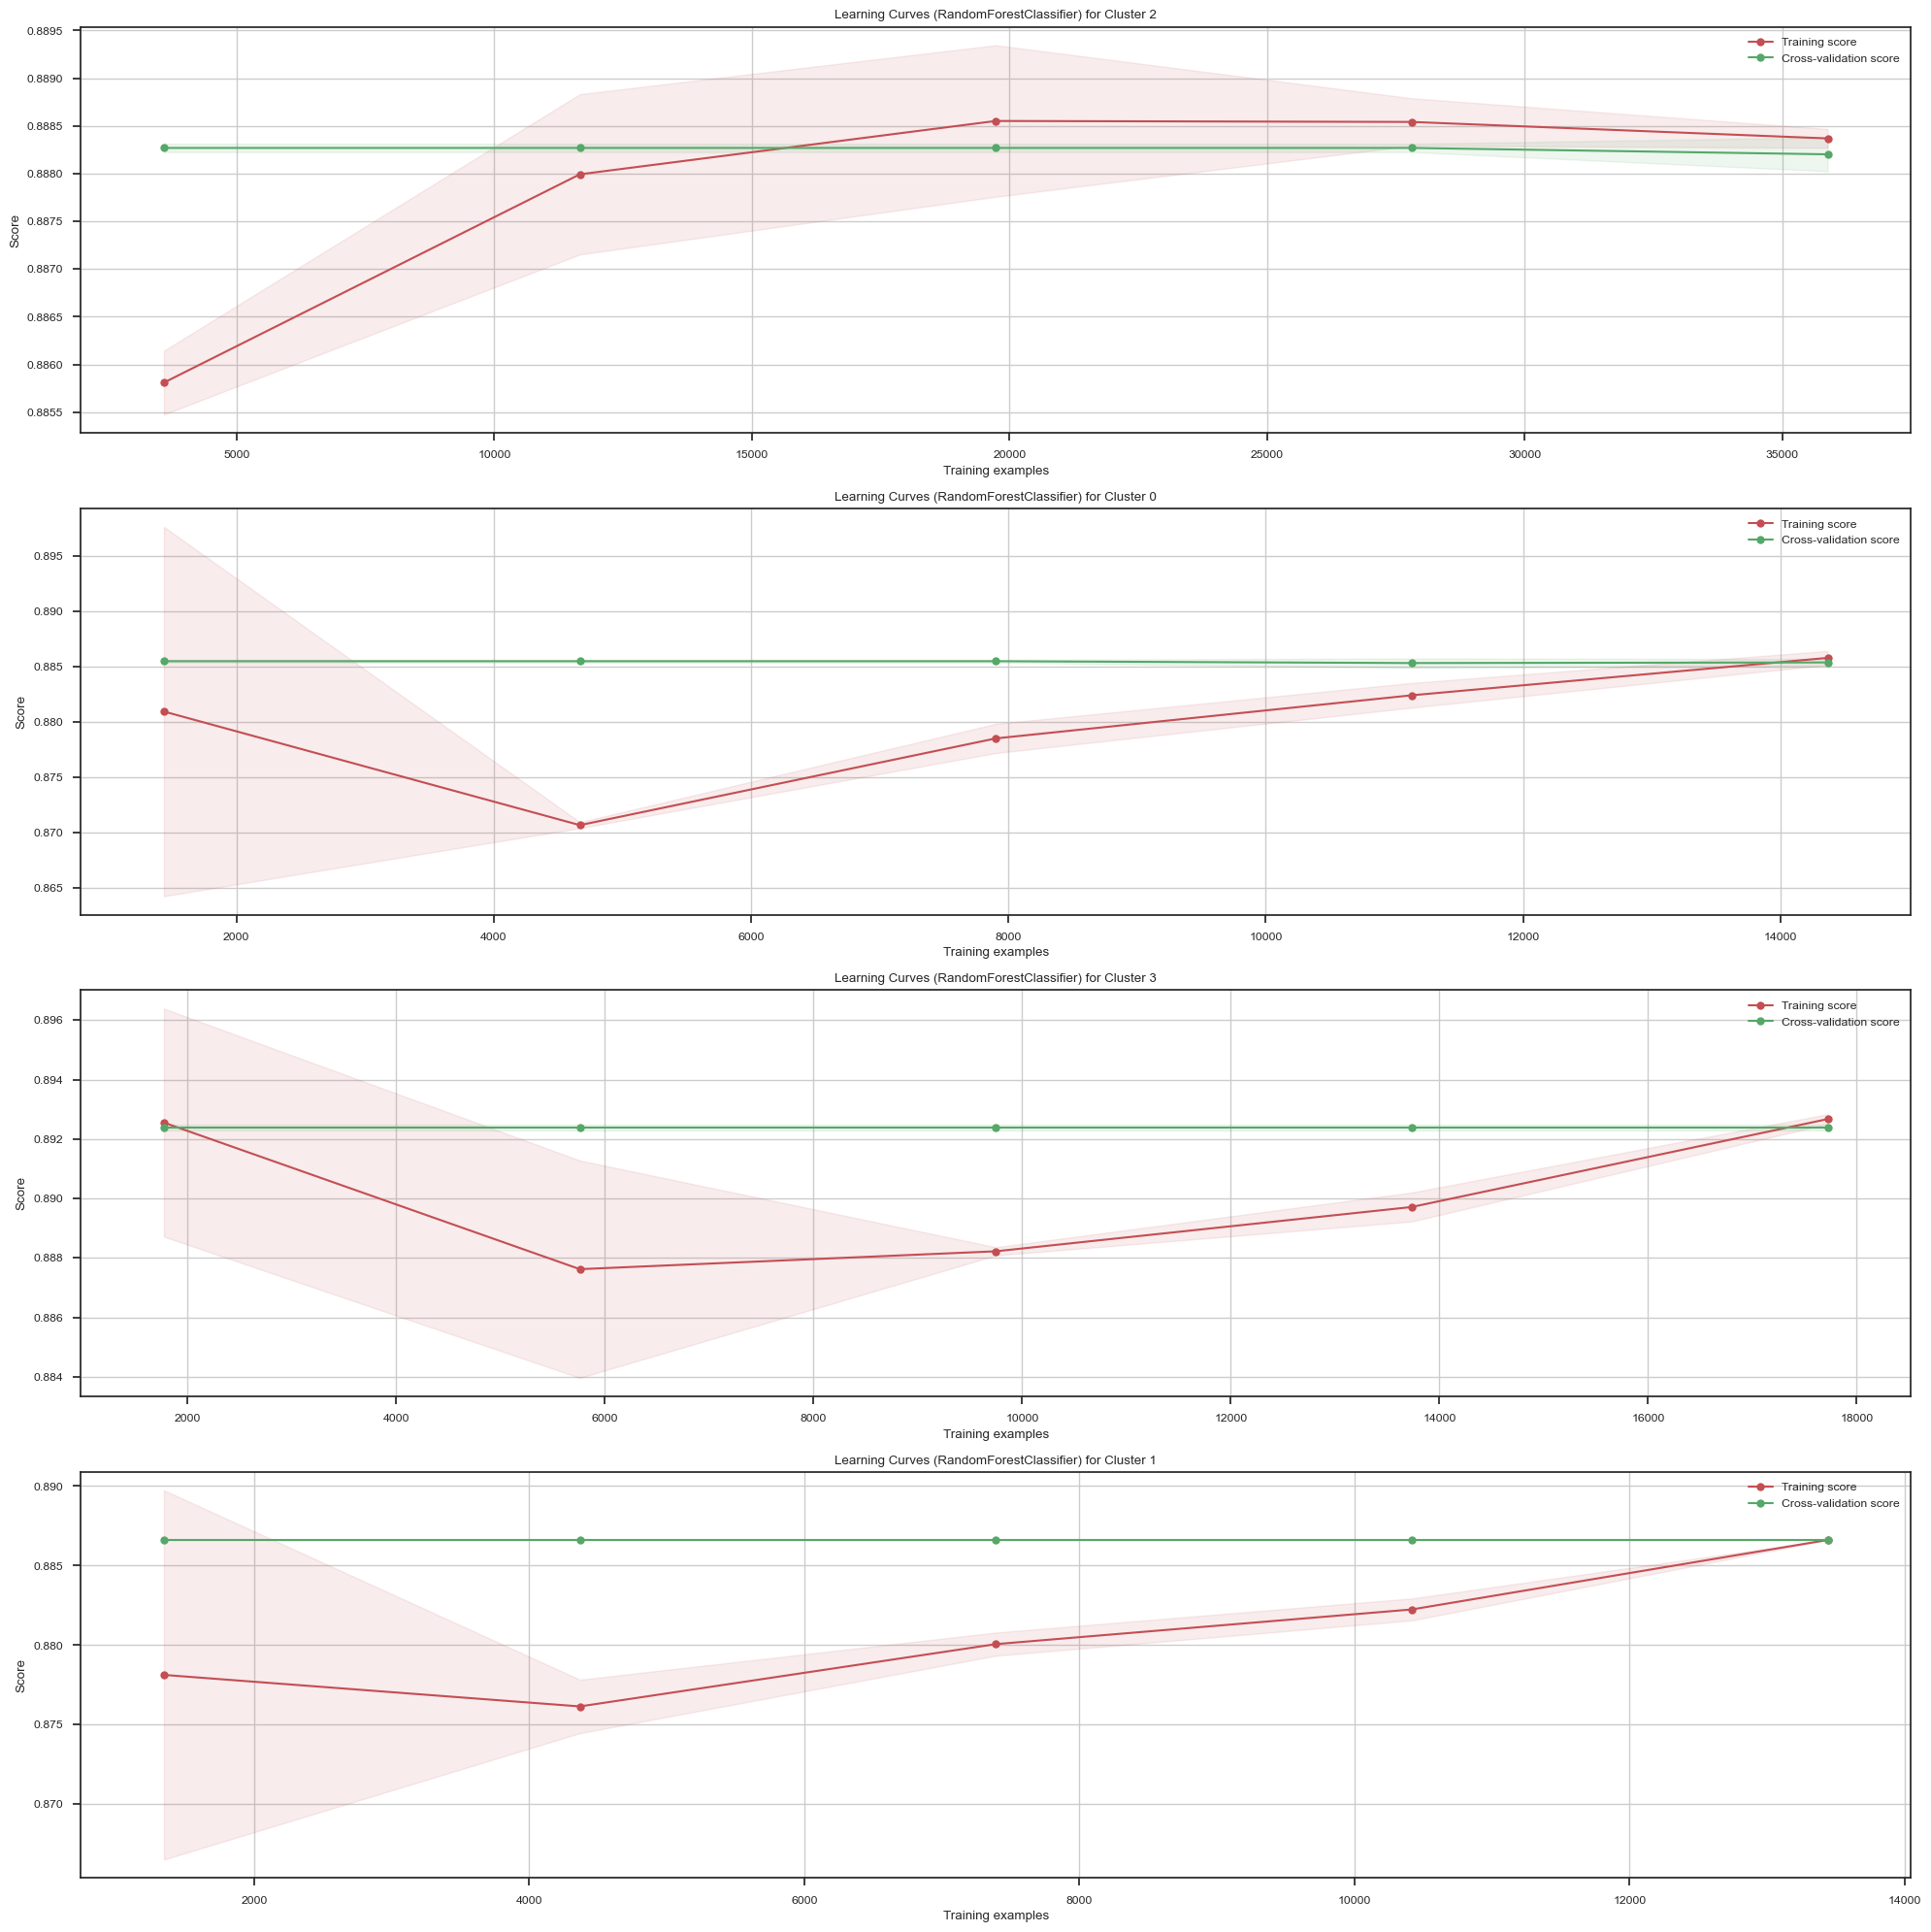

In [703]:

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1,
                      color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")
    axes.legend(loc="best")

    return plt

# Assuming df_encoded is your dataframe with a 'Cluster' column
clusters = df_encoded['Cluster'].unique()

# Setting up the matplotlib figure and axes
fig, axs = plt.subplots(len(clusters), 1, figsize=(20, 5 * len(clusters)))

# Use a 5-fold cross-validation
cv = 5
n_jobs = -1  # Use all available cores

for idx, cluster in enumerate(clusters):
    title = f"Learning Curves (RandomForestClassifier) for Cluster {cluster}"

    # Select data for the current cluster
    cluster_data = df_encoded[df_encoded['Cluster'] == cluster]
    X_cluster = cluster_data.drop(['readmitted', 'Cluster'], axis=1)
    y_cluster = cluster_data['readmitted']

    # Plot learning curve for the current cluster
    plot_learning_curve(rf, title, X_cluster, y_cluster, axes=axs[idx], cv=cv, n_jobs=n_jobs)

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()